In [1]:
# script to run simulations of stream peppering
import os, os.path
import csv
import time
import pickle
import matplotlib
#matplotlib.use('agg')
import numpy
from scipy import integrate, interpolate
from optparse import OptionParser
from galpy.util import bovy_conversion
import gd1_util
import pal5_util
from gd1_util import R0,V0
from scipy.integrate import quad
from scipy.optimize import brentq
import GMC_GC_util
import glob
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
from numpy.polynomial import Polynomial
from gd1_util_MWhaloshape import lb_to_phi12

Populating the interactive namespace from numpy and matplotlib


In [2]:
#All the functions
def compute_obs_density(phi1,apars,dens_apar,Omega):
    
    apar_edge=[]
    phi1_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    phi1bw0=phi1[1]-phi1[0]
    phi1_edge.append(phi1[0]-(phi1bw0/2.))

    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        phi1bw=phi1[ii+1]-phi1[ii]
        apar_edge.append(apars[ii]+abw/2.)
        phi1_edge.append(phi1[ii]+phi1bw/2.)

    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    phi1bw_last=phi1[len(phi1)-1]-phi1[len(phi1)-2]
    phi1_edge.append(phi1[len(phi1)-1]+(phi1bw_last/2.))

    #compute the Jacobian d(apar)/d(phi1) using finite difference method
    dapar_dphi1=np.fabs(numpy.diff(apar_edge)/numpy.diff(phi1_edge))
    #print (dapar_dphi1)
   
    #Interpolate dens(apar)
    ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens_apar)

    #Interpolate apar(phi1)
    if phi1[1] < phi1[0] : # ad-hoc way of checking whether increasing or decreasing
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1[::-1],apars[::-1])
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dapar_dphi1[::-1])
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],ipdens_apar(ipphi1(phi1[::-1]))*ipdapar_dphi1(phi1[::-1]))
        
    else :
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apars)
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1,dapar_dphi1)
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,ipdens_apar(ipphi1(phi1))*ipdapar_dphi1(phi1))
       
    return (dens_phi1(phi1))

def get_data(arm='trailing',poly_deg=3,gap_width=12.):
    
    #load's deBoer's data after selecting between phi1_min and phi1_max
    #
    gaia_dat=np.genfromtxt('fromDenis/GD1_stream_track_density_uncorr.dat',names=True)
    midphi1=gaia_dat['phi1mid']
    lin_den = gaia_dat['lindens']
    elin_den=gaia_dat['e_lindens']
    phi2=gaia_dat['phi2']
    ephi2=gaia_dat['e_phi2']

    print (min(midphi1),max(midphi1))
    
    if arm == 'leading' :
        phi1_min=-60.
        phi1_max=-40 -(gap_width*0.5)  #-42. 
        
    else :
        phi1_min=-40 +(gap_width*0.5) 
        phi1_max=-4. #-4.   
        
    phi1_cut = midphi1[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    lin_den_cut = lin_den[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    elin_den_cut = elin_den[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    phi2_cut = phi2[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    ephi2_cut = ephi2[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    
    #fit 3rd order polynomial
    pp= Polynomial.fit(phi1_cut,lin_den_cut,deg=poly_deg,w=1/(elin_den_cut))  #for linear density
    pp_phi2= Polynomial.fit(phi1_cut,phi2_cut,deg=poly_deg,w=1/(ephi2_cut))   # for track
    
    #normalize density, track and errors
    norm_den = lin_den_cut/pp(phi1_cut)
    norm_den_err = elin_den_cut/pp(phi1_cut)
    norm_phi2_cut= phi2_cut - pp_phi2(phi1_cut)
    
    return (phi1_cut,phi2_cut,norm_den,norm_den_err,norm_phi2_cut,ephi2_cut)  

def compute_length(phi1,dens_phi1,arm='trailing',threshold=0.2):
    
    
    if phi1[1] < phi1[0]:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dens_phi1[::-1])
        
    else:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)
    
    if arm == 'leading' :     
        mean_den=np.mean(dens_phi1[(phi1 >= -44.) & (phi1 <= -40.)])
        try:
            length=np.abs(-40. - brentq(lambda x: ip_dens_phi1(x)-mean_den*threshold,-60.,max(phi1)))
            
        except ValueError:
            length = -40.-(-60.) # full length
            
            
    else :    
        mean_den=np.mean(dens_phi1[(phi1 >= -40.) & (phi1 <= -36.)])
        try:
            #length=np.abs(min(phi1)-brentq(lambda x: ip_dens_phi1(x)-mean_den*threshold,min(phi1),-4.))
            length=np.abs(-40-brentq(lambda x: ip_dens_phi1(x)-mean_den*threshold,min(phi1),-4.))
            #print (length)
        except ValueError as e:
            #print (e)
            #print (dens_phi1)
            length = -4.-(-40.) # full length
              
    return (length)

def compute_pk_data(arm='trailing',gap_width=12.):
    
    # get the data, "arm" incorporates the phi1 cuts           
    phi1,_,norm_den,norm_den_err,_,_=get_data(arm=arm,poly_deg=3,gap_width=gap_width)
    print (len(phi1))   
    px_dat,py_dat= signal.csd(norm_den,norm_den,fs=1./(phi1[1]-phi1[0]),scaling='spectrum',nperseg=len(phi1))
    py_dat= py_dat.real
    px_dat= 1./px_dat
    py_dat= numpy.sqrt(py_dat*(phi1[-1]-phi1[0]))
           
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))

    ppy_noise=numpy.empty((nerrsim,len(px_dat)))

    for ii in range(nerrsim):
        tmock= norm_den_err*numpy.random.normal(size=len(phi1))
        tmock_noise= norm_den + norm_den_err*numpy.random.normal(size=len(phi1))
        ppy_err_dat[ii]= signal.csd(tmock,tmock,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

        ppy_noise[ii]= signal.csd(tmock_noise,tmock_noise,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

    py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(phi1[-1]-phi1[0]))

    ppy_noise_median = numpy.sqrt(numpy.nanmedian(ppy_noise,axis=0)*(phi1[-1]-phi1[0]))
    #print (ppy_noise_median- py_dat)

    ppy_noise.sort(axis=0)

    ppy_noise_low = numpy.sqrt(ppy_noise[int(numpy.round(0.023*nerrsim))]*(phi1[-1]-phi1[0]))
    ppy_noise_high = numpy.sqrt(ppy_noise[int(numpy.round(0.977*nerrsim))]*(phi1[-1]-phi1[0]))
    
    return (px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat)

def compute_obs_dens_from_file(fname,sdf_pepper):
    dat=np.loadtxt(fname)
    l10rate=dat[:,0][0]
    apars=dat[:,1]
    dens_smooth=dat[:,2]
    dens=dat[:,3]
    Omega=dat[:,5]
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
    
    return (l10rate,phi1,dens_phi1)

def compute_obs_dens_from_file_margTage(fname,sdf_pepper):
    dat=np.loadtxt(fname)
    rate=dat[:,0][0]
    Tage=dat[:,1][0]
    apars=dat[:,2]
    dens_smooth=dat[:,3]
    dens=dat[:,4]
    Omega=dat[:,6]
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
    
    return (rate,Tage,phi1,dens_phi1)


def compute_dens_cont(phi1,dens_phi1,outphi1,deg=3):
    if phi1[1] < phi1[0]:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dens_phi1[::-1])

    else:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)

    #compute polynomial and density at outphi1
    ppdens_phi1= Polynomial.fit(outphi1,ip_dens_phi1(outphi1),deg=deg)

    #compute density contrast
    dens_cont=ip_dens_phi1(outphi1)/ppdens_phi1(outphi1)
    
    return (outphi1,dens_cont)

#power spectrum from dens already converted to observed coordinates
def compute_pk_sim(p1,dens_cont,arm='trailing',CDM=True,barspiral=False,gap_width=12.,scaling='spectrum'):
    
    if arm == 'leading' :
        p1min=-60.
        p1max=-40. -(gap_width*0.5)  #-42. 
        
    else :
        p1min=-40. +(gap_width*0.5) #-38.
        p1max=-4.  
        
    ll=p1[(p1min <= p1) & (p1 <= p1max)]
    tdata=dens_cont[(p1min <= p1) & (p1 <= p1max)]
    #print (ll)
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
    
    if barspiral :
        #print ('adding power due to the bar + spiral arms in quadrature')
        #power due to spiral arms and the bar
        datSB= numpy.loadtxt('sampled_bar_spiral/bar_spiral/streamdf_20degcut_obs_coord_{}.dat'.format(arm))
        
        p1SB=datSB[:,0][(p1min <= datSB[:,0]) & (datSB[:,0] <= p1max)]
        
        #print (p1SB)
        tdataSB=datSB[:,1][(p1min <= datSB[:,0]) & (datSB[:,0] <= p1max)]
        
        pxSB,pySB= signal.csd(tdataSB,tdataSB,fs=1./(ll[1]-ll[0]),scaling=scaling,nperseg=len(ll))
        
        pySB= pySB.real # these are already squared
        
    if not barspiral:
        pySB=np.zeros(len(px))

    py+= pySB
                  
    return (1./px,numpy.sqrt(py*(ll[-1]-ll[0])))

def set_ranges_and_labels_dens():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
    ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$')
    ylim(0.01,20.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None  

def set_ranges_and_labels_dens_noY():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
    ylim(0.001,20.)
    xlim(1.,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None 

### Epanechnikov kernels

In [21]:
# Do a Epanechnikov KDE estimate of the PDF in the transformed y=(1+x)/(1-x) space
def kde_epanechnikov_rate(x,h,ydata):
    """ydata= ln[(2+xdata)/(2-xdata)]"""
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((2.1+x)/(2.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(2.1+x)+1./(2.1-x))

def kde_epanechnikov_rate1(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    #h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))


def kde_epanechnikov_slope(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((2.6+x)/(-1.4-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(2.6+x) - 1./(1.4+x))

def kde_epanechnikov_amp(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))

def kde_epanechnikov_mwdm(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(0.01-0.005))/(1.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(x-(0.01-0.005)) + 1./(1.1-x))

def kde_epanechnikov_weighted_mwdm_uniform(x,h,xdata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    ydata=numpy.log((xdata-(1. - 0.1))/(30.1-xdata))
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(1.-0.1))/(30.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.)/xdata**2.,axis=1)/h*np.abs(1./(x-(1.-0.1)) + 1./(30.1-x))

def kde_epanechnikov_loguniform_mwdm(x,h,xdata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    ydata=numpy.log((xdata-(0. - 0.1))/(np.log10(50.)+0.1-xdata))
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(0.-0.1))/(np.log10(50.)+0.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(x-(0.-0.1)) + 1./(np.log10(50.)+0.1-x))


import seaborn as sns
def plot_pdf(rate_array,dat_type='rate',color=sns.color_palette()[0],zorder=8,
                  kernel_width=0.8,
                  add_68peak_95up=False,add_95up=False,add_95low=False,
                  overplot=False,
                  scale=1.,label=''):
    
    rate_full= np.array(rate_array)#abc_full[sindx,0]
    
    if dat_type == 'rate':
        xxs= numpy.linspace(-1.,1.,101)
        kdey_full= kde_epanechnikov_rate1(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{rate} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                                % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)+'\n'+r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10**uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{rate} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{rate} >%.4f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
                               size=16.,top_left=True)
        legend(loc='lower left')
        return None
    
    elif dat_type == 'slope':
        xxs= numpy.linspace(-2.5,-1.5,101)
        kdey_full= kde_epanechnikov_slope(xxs,kernel_width,numpy.log((2.6+rate_full)/(-1.4-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha >%.1f \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        legend(loc='upper right')
        return None
    
    elif dat_type == 'amp' : 
        xxs= numpy.linspace(-1.,1.,101)
        kdey_full= kde_epanechnikov_amp(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            bovy_plot.bovy_text(r'$\mathrm{amp} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                                % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)
                                +'\n'+r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)
            
        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{amp} > %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
                               size=16.,top_left=True)

                   
        legend(loc='upper right')
        return None
    
    elif dat_type=='mwdm':
        xxs= numpy.linspace(0.01,1.,101)
        kdey_full= kde_epanechnikov_mwdm(xxs,kernel_width,numpy.log((rate_full-(0.01 - 0.005))/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        legend(loc='upper right')
        
    elif dat_type=='weighted_mwdm_uniform':
        xxs= numpy.linspace(1.,29.,201)
        kdey_full= kde_epanechnikov_weighted_mwdm_uniform(xxs,kernel_width,rate_full)+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)
            
    elif dat_type=='loguniform_mwdm':
        xxs= numpy.linspace(0.,np.log10(50.),101)
        kdey_full= kde_epanechnikov_loguniform_mwdm(xxs,kernel_width,rate_full)+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        
        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (10**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (10**lowlim_95),
                               size=16.,top_left=True)

        legend(loc='upper right')
        
        
    return None



Convert to observable coordinates and also use Rao-Blackwellization to generate 100 more realizations for each case. Remove the buggy realizations due to Nan or Infs. Use length of the stream to decide whether to accept or reject it. Compute power diff and write out in the diff file. 

### ABC for mwdm, log uniform, marginalized on Tage

In [4]:
def compute_power_loguniform_mwdm_margTage(dir='dens_Omega/sims_for_ABC_loguniformmwdm_margTage/',Nbatch=400,Nind=50,len_threshold=0.2,RaoblackwellizeN=100):
                  
    rand_age=np.loadtxt("random_loguniformAmp_uniformSlope_loguniformMwdm.dat")[:,0]
    batchsize = Nind
    
    dir1_tr=dir+'trailing/'
    dir1_le=dir+'leading/'
    
    px_dat_tr,py_noise_med_tr,py_noise_low_tr,py_noise_high_tr,py_err_dat_tr = compute_pk_data(arm='trailing')
    px_dat_le,py_noise_med_le,py_noise_low_le,py_noise_high_le,py_err_dat_le = compute_pk_data(arm='leading')
       
    
    fot = open(dir + 'ABC_loguniform_mwdm_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
    fol = open(dir + 'ABC_loguniform_mwdm_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
    
    fowritert= csv.writer(fot,delimiter=',')
    fowriterl= csv.writer(fol,delimiter=',')
    
    fowritert.writerow([pp for pp in px_dat_tr[1:]])
    fowriterl.writerow([pp for pp in px_dat_le[1:]])
    
    #get the phi1 from the data
    outphi1t,_,_,norm_data_errt,_,_=get_data(arm='trailing')
    outphi1l,_,_,norm_data_errl,_,_=get_data(arm='leading')
    
    trail_len=36.
    lead_len=20.
    err_count=0
    for bb in range(Nbatch):
        for ind in range(Nind):
            jj = (bb*batchsize) + ind
            Tage = rand_age[jj]
            sigv=np.round((0.3*3.2)/Tage,2)
            
            midphi1_lead,pert_lead=np.loadtxt('combine_bar_spiral_subhalos/GD1_{}Gyr_sigv{}_leading_barspiral_1M_perturbation.dat'.format(Tage,sigv),unpack=True)
            midphi1_trail,pert_trail=np.loadtxt('combine_bar_spiral_subhalos/GD1_{}Gyr_sigv{}_trailing_barspiral_1M_perturbation.dat'.format(Tage,sigv),unpack=True)
            
            ip_lead_pert=interpolate.InterpolatedUnivariateSpline(midphi1_lead,pert_lead)
            ip_trail_pert=interpolate.InterpolatedUnivariateSpline(midphi1_trail,pert_trail)
            
               
            with open('pkl_files/pklfiles_{}Gyr_sigv{}/gd1_smooth_pepper_trailing_Plummer_sigv{}_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(Tage,sigv,sigv,Tage),'rb') as savefile:
                sdf_smooth_t= pickle.load(savefile,encoding='latin1')
                sdf_pepper_t= pickle.load(savefile,encoding='latin1')
            
            with open('pkl_files/pklfiles_{}Gyr_sigv{}/gd1_smooth_pepper_leading_Plummer_sigv{}_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(Tage,sigv,sigv,Tage),'rb') as savefile:
                sdf_smooth_l= pickle.load(savefile,encoding='latin1')
                sdf_pepper_l= pickle.load(savefile,encoding='latin1')
            
              
            fnamet=dir1_tr + 'GD1_prog-40.0_sigv{}_trailing_densOmega_sub_GMC_GC_loguniformmwdm_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            fnamel=dir1_le + 'GD1_prog-40.0_sigv{}_leading_densOmega_sub_GMC_GC_loguniformmwdm_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            
            try:
                mwdm,_,phi1_t,dens_phi1_t = compute_obs_dens_from_file_margTage(fnamet,sdf_pepper_t)
                _,_,phi1_l,dens_phi1_l = compute_obs_dens_from_file_margTage(fnamel,sdf_pepper_l)

                pert_BS_lead=ip_lead_pert(phi1_l)
                pert_BS_trail=ip_trail_pert(phi1_t)

                #add perturbation due to the bar + spiral
                dens_phi1_l+=pert_BS_lead
                dens_phi1_t+=pert_BS_trail

                #compute length
                l_trail=compute_length(phi1_t,dens_phi1_t,arm='trailing',threshold=len_threshold)
                l_lead=compute_length(phi1_l,dens_phi1_l,arm='leading',threshold=len_threshold)

                #if either arm is shorter than observed then PENALIZE! 
                if (l_trail < trail_len) | (l_lead < lead_len) :
                    #print (l10rate,l_trail, l_lead)
                    prej_tr = 100.*np.ones(len(px_dat_tr)-1) #some huge number so that this gets rejected
                    prej_le = 100.*np.ones(len(px_dat_le)-1) #some huge number so that this gets rejected

                    prej_tr=np.insert(prej_tr,0,[mwdm,Tage])
                    prej_le=np.insert(prej_le,0,[mwdm,Tage])
                    for ii in range(RaoblackwellizeN+1):
                        fowritert.writerow([p1 for p1 in prej_tr])
                        fowriterl.writerow([p1 for p1 in prej_le])

                else :

                    _,dens_cont_tr=compute_dens_cont(phi1_t,dens_phi1_t,outphi1t)
                    _,dens_cont_le=compute_dens_cont(phi1_l,dens_phi1_l,outphi1l)

                    px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,dens_cont_tr,arm='trailing',CDM=True,scaling='spectrum')
                    px_sim_le,py_sim_le = compute_pk_sim(outphi1l,dens_cont_le,arm='leading',CDM=True,scaling='spectrum')

                    diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                    diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                    diff_t=np.insert(diff_t,0,[mwdm,Tage])
                    diff_l=np.insert(diff_l,0,[mwdm,Tage])

                    fowritert.writerow([pp for pp in diff_t])
                    fowriterl.writerow([pp for pp in diff_l])

                    for jj in range(RaoblackwellizeN):
                        tdens_tr= dens_cont_tr+numpy.random.normal(size=len(outphi1t))*norm_data_errt
                        tdens_le= dens_cont_le+numpy.random.normal(size=len(outphi1l))*norm_data_errl

                        px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,tdens_tr,arm='trailing',CDM=True,scaling='spectrum')
                        px_sim_le,py_sim_le = compute_pk_sim(outphi1l,tdens_le,arm='leading',CDM=True,scaling='spectrum')

                        diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                        diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                        diff_t=np.insert(diff_t,0,[mwdm,Tage])
                        diff_l=np.insert(diff_l,0,[mwdm,Tage])

                        fowritert.writerow([pp for pp in diff_t])
                        fowriterl.writerow([pp for pp in diff_l])

            except ValueError as e:
                    pass
                    err_count+=1
                    #print (jj)
                    #print (e)
                    #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
    fot.flush()
    fol.flush()
    fot.close() 
    fol.close() 
    print (err_count)
    return None
            
            

In [5]:
compute_power_loguniform_mwdm_margTage(Nbatch=200)

-90.0 30.0
16
C:\Users\nbani\Anaconda3\lib\site-packages\ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in true_divide

-90.0 30.0
8
-90.0 30.0
-90.0 30.0
C:\Users\nbani\Anaconda3\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: divide by zero encountered in true_divide

31


In [11]:
#read the diff file and construct the posterior after combining both the leading and trailing arm

dir2 = 'dens_Omega/sims_for_ABC_loguniformmwdm_margTage/'


abc_diff_tr=np.loadtxt(dir2 + 'ABC_loguniform_mwdm_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'ABC_loguniform_mwdm_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.6
tol_tr_med=0.5
tol_tr_lo=0.4
    

tol_le_hi=0.6
tol_le_med=0.5
tol_le_lo=0.4
   

accepted_mwdm=[]
mwdm_all=[]
accepted_Tage=[]
Tage_all=[]

NN=len(abc_diff_tr)

for ii in range(NN):
    #print (abc_diff[ii])
    mwdm=abc_diff_tr[ii][0]
    mwdm_all.append(np.log10(mwdm))
    Tage=abc_diff_tr[ii][1]
    Tage_all.append(Tage)
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][2]
    diff_tr_med=abc_diff_tr[ii][3]
    diff_tr_lo=abc_diff_tr[ii][4]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][2]
    diff_le_med=abc_diff_le[ii][3]
    diff_le_lo=abc_diff_le[ii][4]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
        
        accepted_mwdm.append(np.log10(mwdm))
        accepted_Tage.append(Tage)
        
print (len(abc_diff_tr), len(accepted_mwdm))

1006869 110973


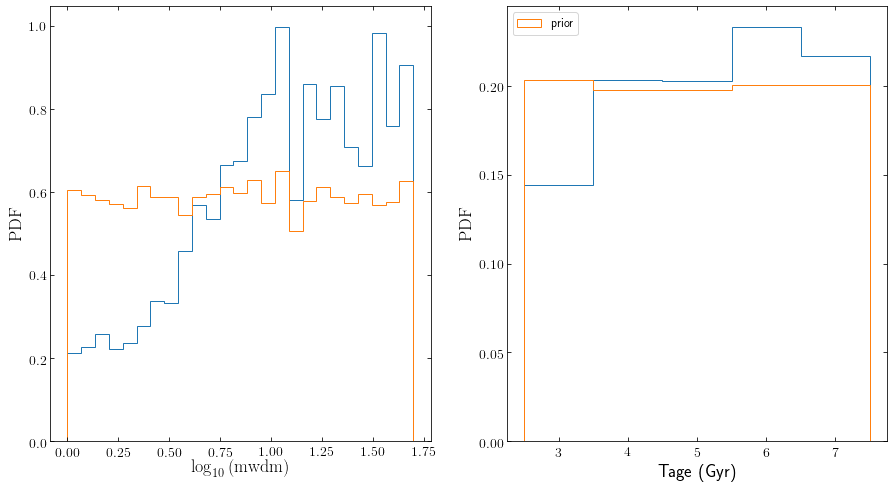

In [15]:
#rand_rate=np.loadtxt("random_loguniformAmp_uniformSlope_loguniformMwdm.dat")[:,0]

#mwdm_bins=np.linspace(0.,np.log10(50.),15)
#midbin=np.array([0.5*(mwdm_bins[ii] + mwdm_bins[ii+1]) for ii in range(len(mwdm_bins)-1)])
#count,bin_edge=np.histogram(accepted_mwdm,mwdm_bins,density=True)
#count_prior,_=np.histogram(rand_rate,rredge,density=True)


Tage_bin=[2.5,3.5,4.5,5.5,6.5,7.5]
midTage=[3.,4.,5.,6.,7.]


plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.hist(accepted_mwdm,bins=25,density=True,histtype='step')
plt.hist(mwdm_all,bins=25,density=True,histtype='step')
#plt.plot(midbin,count)
plt.xlabel(r'$\log_{10}\left(\mathrm{mwdm}\right)$')
plt.ylabel(r'$\mathrm{PDF}$')

plt.subplot(1,2,2)
plt.hist(accepted_Tage,bins=Tage_bin,density=True,histtype='step')
plt.hist(Tage_all,bins=Tage_bin,density=True,histtype='step',label='prior')
plt.legend(loc='upper left')
#plt.ylabel("PDF")
plt.xlabel(r'Tage (Gyr)')
plt.ylabel(r'$\mathrm{PDF}$')

#plt.savefig('hist_lognormal1sigmarate_hist_prior_posterior.pdf')

plt.show()

No handles with labels found to put in legend.


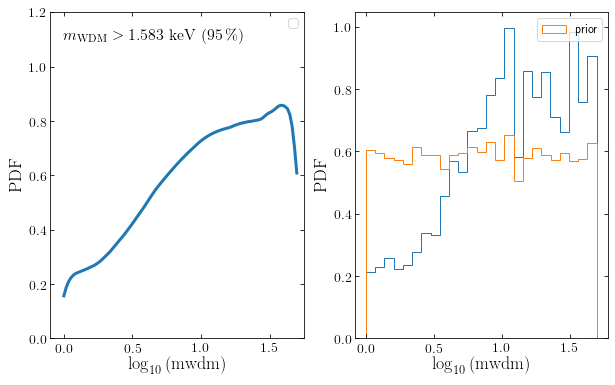

In [35]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(10,6)
cmap= cm.plasma
subplot(1,2,1)
plot_pdf(accepted_mwdm,dat_type='loguniform_mwdm',add_68peak_95up=False,add_95up=False,add_95low=True,kernel_width=1.,label=r'',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{mwdm}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-0.1,1.75)
ylim(0.,1.2)

subplot(1,2,2)
plt.hist(accepted_mwdm,bins=25,density=True,histtype='step')
plt.hist(mwdm_all,bins=25,density=True,histtype='step',label='prior')
#plt.savefig('hist_lognormal1sigmarate_hist_prior_posterior.pdf')
xlabel(r'$\log_{10}\left(\mathrm{mwdm}\right)$')
ylabel(r'$\mathrm{PDF}$')
legend(loc='upper right')
#savefig("ABC_posterior_lognormal_1sigma rate_margTage.pdf")

In [36]:
print (10**(np.percentile(accepted_mwdm,q=5,interpolation='midpoint')))

#print (np.log10(50.))

1.645095943574095


### ABC for rate relative to CDM, uniform prior, marginalized on Tage

In [ ]:
def compute_power_diff_rate_margTage(dir='dens_Omega/sims_for_ABC_loguniform_rate_margTage/',Nbatch=20,Nind=50,len_threshold=0.2,RaoblackwellizeN=100):
                  
    rand_age=np.loadtxt("random_loguniform_rate_margTage.dat")[:,1]
    batchsize = Nind
    
    dir1_tr=dir+'trailing/'
    dir1_le=dir+'leading/'
    
    px_dat_tr,py_noise_med_tr,py_noise_low_tr,py_noise_high_tr,py_err_dat_tr = compute_pk_data(arm='trailing')
    px_dat_le,py_noise_med_le,py_noise_low_le,py_noise_high_le,py_err_dat_le = compute_pk_data(arm='leading')
       
    
    fot = open(dir + 'ABC_uniform_rate_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
    fol = open(dir + 'ABC_uniform_rate_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
    
    fowritert= csv.writer(fot,delimiter=',')
    fowriterl= csv.writer(fol,delimiter=',')
    
    fowritert.writerow([pp for pp in px_dat_tr[1:]])
    fowriterl.writerow([pp for pp in px_dat_le[1:]])
    
    #get the phi1 from the data
    outphi1t,_,_,norm_data_errt,_,_=get_data(arm='trailing')
    outphi1l,_,_,norm_data_errl,_,_=get_data(arm='leading')
    
    trail_len=36.
    lead_len=20.
    err_count=0
    for bb in range(Nbatch):
        for ind in range(Nind):
            jj = (bb*batchsize) + ind
            Tage = rand_age[jj]
            sigv=np.round((0.3*3.2)/Tage,2)
            
            midphi1_lead,pert_lead=np.loadtxt('combine_bar_spiral_subhalos/GD1_{}Gyr_sigv{}_leading_barspiral_1M_perturbation.dat'.format(Tage,sigv),unpack=True)
            midphi1_trail,pert_trail=np.loadtxt('combine_bar_spiral_subhalos/GD1_{}Gyr_sigv{}_trailing_barspiral_1M_perturbation.dat'.format(Tage,sigv),unpack=True)
            
            ip_lead_pert=interpolate.InterpolatedUnivariateSpline(midphi1_lead,pert_lead)
            ip_trail_pert=interpolate.InterpolatedUnivariateSpline(midphi1_trail,pert_trail)
            
               
            with open('pkl_files/pklfiles_{}Gyr_sigv{}/gd1_smooth_pepper_trailing_Plummer_sigv{}_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(Tage,sigv,sigv,Tage),'rb') as savefile:
                sdf_smooth_t= pickle.load(savefile,encoding='latin1')
                sdf_pepper_t= pickle.load(savefile,encoding='latin1')
            
            with open('pkl_files/pklfiles_{}Gyr_sigv{}/gd1_smooth_pepper_leading_Plummer_sigv{}_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(Tage,sigv,sigv,Tage),'rb') as savefile:
                sdf_smooth_l= pickle.load(savefile,encoding='latin1')
                sdf_pepper_l= pickle.load(savefile,encoding='latin1')
            
              
            fnamet=dir1_tr + 'GD1_prog-40.0_sigv{}_trailing_densOmega_sub_GMC_GC_loguniform_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            fnamel=dir1_le + 'GD1_prog-40.0_sigv{}_leading_densOmega_sub_GMC_GC_loguniform_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            
            try:
                rate,_,phi1_t,dens_phi1_t = compute_obs_dens_from_file_margTage(fnamet,sdf_pepper_t)
                _,_,phi1_l,dens_phi1_l = compute_obs_dens_from_file_margTage(fnamel,sdf_pepper_l)

                pert_BS_lead=ip_lead_pert(phi1_l)
                pert_BS_trail=ip_trail_pert(phi1_t)

                #add perturbation due to the bar + spiral
                dens_phi1_l+=pert_BS_lead
                dens_phi1_t+=pert_BS_trail

                #compute length
                l_trail=compute_length(phi1_t,dens_phi1_t,arm='trailing',threshold=len_threshold)
                l_lead=compute_length(phi1_l,dens_phi1_l,arm='leading',threshold=len_threshold)

                #if either arm is shorter than observed then PENALIZE! 
                if (l_trail < trail_len) | (l_lead < lead_len) :
                    #print (l10rate,l_trail, l_lead)
                    prej_tr = 100.*np.ones(len(px_dat_tr)-1) #some huge number so that this gets rejected
                    prej_le = 100.*np.ones(len(px_dat_le)-1) #some huge number so that this gets rejected

                    prej_tr=np.insert(prej_tr,0,[rate,Tage])
                    prej_le=np.insert(prej_le,0,[rate,Tage])
                    for ii in range(RaoblackwellizeN+1):
                        fowritert.writerow([p1 for p1 in prej_tr])
                        fowriterl.writerow([p1 for p1 in prej_le])

                else :

                    _,dens_cont_tr=compute_dens_cont(phi1_t,dens_phi1_t,outphi1t)
                    _,dens_cont_le=compute_dens_cont(phi1_l,dens_phi1_l,outphi1l)

                    px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,dens_cont_tr,arm='trailing',CDM=True,scaling='spectrum')
                    px_sim_le,py_sim_le = compute_pk_sim(outphi1l,dens_cont_le,arm='leading',CDM=True,scaling='spectrum')

                    diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                    diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                    diff_t=np.insert(diff_t,0,[rate,Tage])
                    diff_l=np.insert(diff_l,0,[rate,Tage])

                    fowritert.writerow([pp for pp in diff_t])
                    fowriterl.writerow([pp for pp in diff_l])

                    for jj in range(RaoblackwellizeN):
                        tdens_tr= dens_cont_tr+numpy.random.normal(size=len(outphi1t))*norm_data_errt
                        tdens_le= dens_cont_le+numpy.random.normal(size=len(outphi1l))*norm_data_errl

                        px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,tdens_tr,arm='trailing',CDM=True,scaling='spectrum')
                        px_sim_le,py_sim_le = compute_pk_sim(outphi1l,tdens_le,arm='leading',CDM=True,scaling='spectrum')

                        diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                        diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                        diff_t=np.insert(diff_t,0,[rate,Tage])
                        diff_l=np.insert(diff_l,0,[rate,Tage])

                        fowritert.writerow([pp for pp in diff_t])
                        fowriterl.writerow([pp for pp in diff_l])

            except ValueError as e:
                    pass
                    err_count+=1
                    #print (jj)
                    #print (e)
                    #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
    fot.flush()
    fol.flush()
    fot.close() 
    fol.close() 
    print (err_count)
    return None
            
            

In [ ]:
compute_power_diff_rate_margTage()

In [ ]:
#read the diff file and construct the posterior after combining both the leading and trailing arm

dir2 = 'dens_Omega/sims_for_ABC_loguniform_rate_margTage/'


abc_diff_tr=np.loadtxt(dir2 + 'ABC_uniform_rate_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'ABC_uniform_rate_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.6
tol_tr_med=0.5
tol_tr_lo=0.4
    

tol_le_hi=0.6
tol_le_med=0.5
tol_le_lo=0.4
   

accepted_rate=[]
rate_all=[]
accepted_Tage=[]
Tage_all=[]

NN=len(abc_diff_tr)

for ii in range(NN):
    #print (abc_diff[ii])
    rate=abc_diff_tr[ii][0]
    rate_all.append(np.log10(rate))
    Tage=abc_diff_tr[ii][1]
    Tage_all.append(Tage)
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][2]
    diff_tr_med=abc_diff_tr[ii][3]
    diff_tr_lo=abc_diff_tr[ii][4]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][2]
    diff_le_med=abc_diff_le[ii][3]
    diff_le_lo=abc_diff_le[ii][4]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
        
        accepted_rate.append(np.log10(rate))
        accepted_Tage.append(Tage)
        
print (len(abc_diff_tr), len(accepted_rate))

rr=np.linspace(-0.8,0.5,30)

bw=rr[1]-rr[0]


rredge=[rr[0] + i*bw for i in range(len(rr)+1)]

#print (rredge)

rand_rate=np.loadtxt("random_loguniform_rate_margTage.dat")[:,0]

count,bin_edge=np.histogram(accepted_rate,rredge,density=True)
count_prior,_=np.histogram(rand_rate,rredge,density=True)


Tage_bin=[2.5,3.5,4.5,5.5,6.5,7.5]
midTage=[3.,4.,5.,6.,7.]


plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.hist(accepted_rate,bins=35,density=True,histtype='step')
plt.hist(rate_all,bins=35,density=True,histtype='step')
plt.xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
plt.ylabel(r'$\mathrm{PDF}$')

plt.subplot(1,2,2)
plt.hist(accepted_Tage,bins=Tage_bin,density=True,histtype='step')
plt.hist(Tage_all,bins=Tage_bin,density=True,histtype='step',label='prior')
plt.legend(loc='upper left')
#plt.ylabel("PDF")
plt.xlabel(r'Tage (Gyr)')
plt.ylabel(r'$\mathrm{PDF}$')

#plt.savefig('hist_lognormal1sigmarate_hist_prior_posterior.pdf')

plt.show()


In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(10,6)
cmap= cm.plasma
subplot(1,2,1)
plot_pdf(accepted_rate,dat_type='rate',add_68peak_95up=True,add_95up=False,add_95low=False,kernel_width=0.6,label=r'',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.2,1.2)
ylim(0.,1.2)

subplot(1,2,2)
plt.hist(accepted_rate,bins=35,density=True,histtype='step')
plt.hist(rate_all,bins=35,density=True,histtype='step',label='prior')
plt.savefig('hist_lognormal1sigmarate_hist_prior_posterior.pdf')
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
legend(loc='upper right')
#savefig("ABC_posterior_lognormal_1sigma rate_margTage.pdf")

In [ ]:
print (10**(np.percentile(accepted_rate,q=95,interpolation='midpoint')))

### ABC for rate relative to CDM, uniform prior


In [ ]:
def compute_power_diff_samerate(dir='dens_Omega/ABC_sims_samerate/',Nbatch=20,Nind=50,len_threshold=0.2,barspiral=False,RaoblackwellizeN=100):
                  
    with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_trailing_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_smooth_t= pickle.load(savefile,encoding='latin1')
            sdf_pepper_t= pickle.load(savefile,encoding='latin1')
            
    with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_leading_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_smooth_l= pickle.load(savefile,encoding='latin1')
            sdf_pepper_l= pickle.load(savefile,encoding='latin1')
            
    px_dat_tr,py_noise_med_tr,py_noise_low_tr,py_noise_high_tr,py_err_dat_tr = compute_pk_data(arm='trailing')
    px_dat_le,py_noise_med_le,py_noise_low_le,py_noise_high_le,py_err_dat_le = compute_pk_data(arm='leading')
    
    dir1_tr=dir+'trailing/'
    dir1_le=dir+'leading/'
    
    #trash_dir=dir + 'trash/'
    
    if barspiral:
        print ('adding power due to the bar + spiral arms in quadrature')
        fot = open(dir + 'ABC_samerate_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w')
        fol = open(dir + 'ABC_samerate_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w')
    else :
        fot = open(dir + 'ABC_samerate_power_diff_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w')
        fol = open(dir + 'ABC_samerate_power_diff_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w')
    
    fowritert= csv.writer(fot,delimiter=',')
    fowriterl= csv.writer(fol,delimiter=',')
    
    fowritert.writerow([pp for pp in px_dat_tr[1:]])
    fowriterl.writerow([pp for pp in px_dat_le[1:]])
    
    #get the phi1 from the data
    outphi1t,_,_,norm_data_errt,_,_=get_data(arm='trailing')
    outphi1l,_,_,norm_data_errl,_,_=get_data(arm='leading')
    
    trail_len=36.
    lead_len=20.
    
    for bb in range(Nbatch):
        for ind in range(Nind):
            
            fnamet=dir1_tr + 'GD1_prog-40.0_sigv0.3_trailing_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(bb,ind)  
            fnamel=dir1_le + 'GD1_prog-40.0_sigv0.3_leading_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(bb,ind)  
            
            try:
                l10rate,phi1_t,dens_phi1_t = compute_obs_dens_from_file(fnamet,sdf_pepper_t)
                _,phi1_l,dens_phi1_l = compute_obs_dens_from_file(fnamel,sdf_pepper_l)
                
                #compute length
                l_trail=compute_length(phi1_t,dens_phi1_t,arm='trailing',threshold=len_threshold)
                l_lead=compute_length(phi1_l,dens_phi1_l,arm='leading',threshold=len_threshold)
                
                #if either arm is shorter than observed then PENALIZE! 
                if (l_trail < trail_len) | (l_lead < lead_len) :
                    #print (l10rate,l_trail, l_lead)
                    prej_tr = 100.*np.ones(len(px_dat_tr)-1) #some huge number so that this gets rejected
                    prej_le = 100.*np.ones(len(px_dat_le)-1) #some huge number so that this gets rejected
                    
                    prej_tr=np.insert(prej_tr,0,l10rate)
                    prej_le=np.insert(prej_le,0,l10rate)
                    for ii in range(RaoblackwellizeN+1):
                        fowritert.writerow([p1 for p1 in prej_tr])
                        fowriterl.writerow([p1 for p1 in prej_le])

                else :
                    
                    _,dens_cont_tr=compute_dens_cont(phi1_t,dens_phi1_t,outphi1t)
                    _,dens_cont_le=compute_dens_cont(phi1_l,dens_phi1_l,outphi1l)
                    
                    px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,dens_cont_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum')
                    px_sim_le,py_sim_le = compute_pk_sim(outphi1l,dens_cont_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum')
                    
                    diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                    diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])
                    
                    diff_t=np.insert(diff_t,0,l10rate)
                    diff_l=np.insert(diff_l,0,l10rate)
                    
                    fowritert.writerow([pp for pp in diff_t])
                    fowriterl.writerow([pp for pp in diff_l])

                    for jj in range(RaoblackwellizeN):
                        tdens_tr= dens_cont_tr+numpy.random.normal(size=len(outphi1t))*norm_data_errt
                        tdens_le= dens_cont_le+numpy.random.normal(size=len(outphi1l))*norm_data_errl
                        
                        px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,tdens_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum')
                        px_sim_le,py_sim_le = compute_pk_sim(outphi1l,tdens_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum')
                        
                        diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                        diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                        diff_t=np.insert(diff_t,0,l10rate)
                        diff_l=np.insert(diff_l,0,l10rate)

                        fowritert.writerow([pp for pp in diff_t])
                        fowriterl.writerow([pp for pp in diff_l])

            except ValueError as e:
                    pass
                    #print (jj)
                    #print (e)
                    #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
    fot.flush()
    fol.flush()
    fot.close() 
    fol.close() 
    
    return None
            
            

In [ ]:
compute_power_diff_samerate(barspiral=True,RaoblackwellizeN=100)

In [ ]:
#read the diff file and construct the posterior after combining both the leading and trailing arm

dir2 = 'dens_Omega/ABC_sims_samerate/'


abc_diff_tr=np.loadtxt(dir2 + 'ABC_samerate_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'ABC_samerate_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.9
tol_tr_med=0.7
tol_tr_lo=0.5
    

tol_le_hi=0.5
tol_le_med=0.4
tol_le_lo=0.3
   

accepted_rate=[]

NN=len(abc_diff_tr)

for ii in range(NN):
    #print (abc_diff[ii])
    rate=abc_diff_tr[ii][0]
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][1]
    diff_tr_med=abc_diff_tr[ii][2]
    diff_tr_lo=abc_diff_tr[ii][3]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][1]
    diff_le_med=abc_diff_le[ii][2]
    diff_le_lo=abc_diff_le[ii][3]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
        
        accepted_rate.append(rate)
        
print (len(abc_diff_tr), len(accepted_rate))

rr=np.linspace(-1.,1.,20)

bw=rr[1]-rr[0]


rredge=[rr[0] + i*bw for i in range(len(rr)+1)]

#print (rredge)

count,bin_edge=np.histogram(accepted_rate,rredge)


plt.figure()
plt.plot(rr,count)
plt.show()


In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6.,6.)
cmap= cm.plasma

plot_rate_pdf(accepted_rate,add_limits=True,scale=1.)
title(r'Leading + Trailing')
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.3,1.3)
ylim(0.,1.9)
savefig("Trailing_Leading_bar_spiral_posterior.pdf".format(arm))
    

In [ ]:
dir2 = 'dens_Omega/ABC_sims_samerate/'
abc_diff_trail=np.loadtxt(dir2 + 'ABC_samerate_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)
abc_diff_lead=np.loadtxt(dir2 + 'ABC_samerate_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

print (len(abc_diff_lead)-len(abc_diff_trail))

print (abc_diff_trail[:4])

### amp + slope + mwdm with marginalized Tage


In [ ]:
def compute_obs_dens_from_file_amp_slope_mwdm_margTage(fname,sdf_pepper):
    dat=np.loadtxt(fname)
    amp=dat[:,0][0]
    slope=dat[:,1][0]
    mwdm=dat[:,2][0]
    Tage=dat[:,3][0]
    
    apars=dat[:,4]
    dens_smooth=dat[:,5]
    dens=dat[:,6]
    Omega=dat[:,8]
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
    
    return (slope,amp,mwdm,Tage,phi1,dens_phi1)


#uniform mwdm prior
def compute_power_diff_amp_slope_uniformmwdm_margTage(dir='dens_Omega/sims_for_ABC_lognormalamp3.0sigma_slope_uniformmwdm_margTage/',Nbatch=20,Nind=50,gap_width=12.,len_threshold=0.2,barspiral=False,RaoblackwellizeN=100):
    
    rand_age=np.loadtxt("random_lognormal3.0sigma_amp_slope_uniformmwdm_margTage.dat")[:,0]
    batchsize = Nind
    
    dir1_tr=dir+'trailing/'
    dir1_le=dir+'leading/'
    
    px_dat_tr,py_noise_med_tr,py_noise_low_tr,py_noise_high_tr,py_err_dat_tr = compute_pk_data(arm='trailing')
    px_dat_le,py_noise_med_le,py_noise_low_le,py_noise_high_le,py_err_dat_le = compute_pk_data(arm='leading')
       
    if barspiral:
        print ('adding power due to the bar + spiral arms in quadrature')
        fot = open(dir + 'ABC_lognormalamp_slope_mwdm_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
        fol = open(dir + 'ABC_lognormalamp_slope_mwdm_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
    else :
        fot = open(dir + 'ABC_lognormalamp_slope_mwdm_power_diff_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
        fol = open(dir + 'ABC_lognormalamp_slope_mwdm_power_diff_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
    
    fowritert= csv.writer(fot,delimiter=',')
    fowriterl= csv.writer(fol,delimiter=',')
    
    fowritert.writerow([pp for pp in px_dat_tr[1:]])
    fowriterl.writerow([pp for pp in px_dat_le[1:]])
    
    #get the phi1 from the data
    outphi1t,_,_,norm_data_errt,_,_=get_data(arm='trailing')
    outphi1l,_,_,norm_data_errl,_,_=get_data(arm='leading')
    
    trail_len=36.
    lead_len=20.
    
    for bb in range(Nbatch):
        for ind in range(Nind):
            jj = (bb*batchsize) + ind
            Tage = rand_age[jj]
            sigv=np.round((0.3*3.2)/Tage,2)
            
            with open('pkl_files/pklfiles_{}Gyr_sigv{}/gd1_smooth_pepper_trailing_Plummer_sigv{}_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(Tage,sigv,sigv,Tage),'rb') as savefile:
                sdf_smooth_t= pickle.load(savefile,encoding='latin1')
                sdf_pepper_t= pickle.load(savefile,encoding='latin1')
            
            with open('pkl_files/pklfiles_{}Gyr_sigv{}/gd1_smooth_pepper_leading_Plummer_sigv{}_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(Tage,sigv,sigv,Tage),'rb') as savefile:
                sdf_smooth_l= pickle.load(savefile,encoding='latin1')
                sdf_pepper_l= pickle.load(savefile,encoding='latin1')
            
              
            fnamet=dir1_tr + 'GD1_prog-40.0_sigv{}_trailing_densOmega_onlysubhalo_lognormalamp3.0sigma_slope_uniformmwdm_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            fnamel=dir1_le + 'GD1_prog-40.0_sigv{}_leading_densOmega_onlysubhalo_lognormalamp3.0sigma_slope_uniformmwdm_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
                     
            
            try:
                slope,amp,mwdm,_,phi1_t,dens_phi1_t = compute_obs_dens_from_file_amp_slope_mwdm_margTage(fnamet,sdf_pepper_t)
                _,_,_,_,phi1_l,dens_phi1_l = compute_obs_dens_from_file_amp_slope_mwdm_margTage(fnamel,sdf_pepper_l)
                
                #compute length
                l_trail=compute_length(phi1_t,dens_phi1_t,arm='trailing',threshold=len_threshold)
                l_lead=compute_length(phi1_l,dens_phi1_l,arm='leading',threshold=len_threshold)
                
                #mean_den_l=np.mean(dens_phi1_l[(phi1_l >= -44.) & (phi1_l <= -40.)])
                #mean_den_t=np.mean(dens_phi1_t[(phi1_t >= -40.) & (phi1_t <= -36.)])
                #plt.figure(figsize=(10,6))
                #plt.subplot(1,2,1)
                #plt.plot(phi1_l,dens_phi1_l)
                #plt.hlines(0.2*mean_den_l,-35,-100)
                #plt.vlines(-60.,0.,0.01)
                
                #plt.subplot(1,2,2)
                #plt.plot(phi1_t,dens_phi1_t)
                #plt.hlines(0.2*mean_den_t,-45,0.)
                #plt.vlines(-4.,0.,0.01)
                #plt.show()
                
                #if either arm is shorter than observed then PENALIZE! 
                if (l_trail < trail_len) | (l_lead < lead_len) :
                    #print (l10rate,l_trail, l_lead)
                    #print ("rejected")
                    prej_tr = 100.*np.ones(len(px_dat_tr)-1) #some huge number so that this gets rejected
                    prej_le = 100.*np.ones(len(px_dat_le)-1) #some huge number so that this gets rejected
                    
                    prej_tr=np.insert(prej_tr,0,[amp,slope,mwdm,Tage])
                    prej_le=np.insert(prej_le,0,[amp,slope,mwdm,Tage])
                    for ii in range(RaoblackwellizeN+1):
                        fowritert.writerow([p1 for p1 in prej_tr])
                        fowriterl.writerow([p1 for p1 in prej_le])

                else :
                    
                    _,dens_cont_tr=compute_dens_cont(phi1_t,dens_phi1_t,outphi1t)
                    _,dens_cont_le=compute_dens_cont(phi1_l,dens_phi1_l,outphi1l)
                    
                    px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,dens_cont_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum')
                    px_sim_le,py_sim_le = compute_pk_sim(outphi1l,dens_cont_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum')
                    
                    diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                    diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])
                    
                    diff_t=np.insert(diff_t,0,[amp,slope,mwdm,Tage])
                    diff_l=np.insert(diff_l,0,[amp,slope,mwdm,Tage])
                    
                    fowritert.writerow([pp for pp in diff_t])
                    fowriterl.writerow([pp for pp in diff_l])

                    for jj in range(RaoblackwellizeN):
                        tdens_tr= dens_cont_tr+numpy.random.normal(size=len(outphi1t))*norm_data_errt
                        tdens_le= dens_cont_le+numpy.random.normal(size=len(outphi1l))*norm_data_errl
                        
                        px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,tdens_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum')
                        px_sim_le,py_sim_le = compute_pk_sim(outphi1l,tdens_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum')
                        
                        diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                        diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                        diff_t=np.insert(diff_t,0,[amp,slope,mwdm,Tage])
                        diff_l=np.insert(diff_l,0,[amp,slope,mwdm,Tage])

                        fowritert.writerow([pp for pp in diff_t])
                        fowriterl.writerow([pp for pp in diff_l])

            except ValueError as e:
                    pass
                    #print (jj)
                    #print (e)
                    #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
    fot.flush()
    fol.flush()
    fot.close() 
    fol.close() 
    
    return None


#uniform in 1/mwdm 
def compute_power_diff_amp_slope_mwdm_margTage(dir='dens_Omega/sims_for_ABC_lognormalamp_slope_mwdm_margTage/',Nbatch=20,Nind=50,gap_width=12.,len_threshold=0.2,barspiral=False,RaoblackwellizeN=100):
    
    rand_age=np.loadtxt("random_lognormal3.0sigma_amp_slope_mwdm_margTage.dat")[:,0]
    batchsize = Nind
    
    dir1_tr=dir+'trailing/'
    dir1_le=dir+'leading/'
    
    px_dat_tr,py_noise_med_tr,py_noise_low_tr,py_noise_high_tr,py_err_dat_tr = compute_pk_data(arm='trailing')
    px_dat_le,py_noise_med_le,py_noise_low_le,py_noise_high_le,py_err_dat_le = compute_pk_data(arm='leading')
       
    if barspiral:
        print ('adding power due to the bar + spiral arms in quadrature')
        fot = open(dir + 'ABC_lognormalamp_slope_mwdm_power_diff_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
        fol = open(dir + 'ABC_lognormalamp_slope_mwdm_power_diff_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
    else :
        fot = open(dir + 'ABC_lognormalamp_slope_mwdm_power_diff_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
        fol = open(dir + 'ABC_lognormalamp_slope_mwdm_power_diff_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(len_threshold,RaoblackwellizeN),'w',newline='')
    
    fowritert= csv.writer(fot,delimiter=',')
    fowriterl= csv.writer(fol,delimiter=',')
    
    fowritert.writerow([pp for pp in px_dat_tr[1:]])
    fowriterl.writerow([pp for pp in px_dat_le[1:]])
    
    #get the phi1 from the data
    outphi1t,_,_,norm_data_errt,_,_=get_data(arm='trailing')
    outphi1l,_,_,norm_data_errl,_,_=get_data(arm='leading')
    
    trail_len=36.
    lead_len=20.
    
    for bb in range(Nbatch):
        for ind in range(Nind):
            jj = (bb*batchsize) + ind
            Tage = rand_age[jj]
            sigv=np.round((0.3*3.2)/Tage,2)
            
            with open('pkl_files/pklfiles_{}Gyr_sigv{}/gd1_smooth_pepper_trailing_Plummer_sigv{}_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(Tage,sigv,sigv,Tage),'rb') as savefile:
                sdf_smooth_t= pickle.load(savefile,encoding='latin1')
                sdf_pepper_t= pickle.load(savefile,encoding='latin1')
            
            with open('pkl_files/pklfiles_{}Gyr_sigv{}/gd1_smooth_pepper_leading_Plummer_sigv{}_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(Tage,sigv,sigv,Tage),'rb') as savefile:
                sdf_smooth_l= pickle.load(savefile,encoding='latin1')
                sdf_pepper_l= pickle.load(savefile,encoding='latin1')
            
              
            fnamet=dir1_tr + 'GD1_prog-40.0_sigv{}_trailing_densOmega_onlysubhalo_lognormalamp_slope_mwdm_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            fnamel=dir1_le + 'GD1_prog-40.0_sigv{}_leading_densOmega_onlysubhalo_lognormalamp_slope_mwdm_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            
            file_exists_t = os.path.isfile(fnamet)
            if file_exists_t:
                fnamet=dir1_tr + 'GD1_prog-40.0_sigv{}_trailing_densOmega_onlysubhalo_lognormalamp_slope_mwdm_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            else:
                fnamet=dir1_tr + 'GD1_prog-40.0_sigv{}_trailing_densOmega_onlysubhalo_lognormalamp3.0sigma_slope_mwdm_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            
            file_exists_l = os.path.isfile(fnamel)
            if file_exists_l:
                fnamel=dir1_le + 'GD1_prog-40.0_sigv{}_leading_densOmega_onlysubhalo_lognormalamp_slope_mwdm_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            else:
                fnamel=dir1_le + 'GD1_prog-40.0_sigv{}_leading_densOmega_onlysubhalo_lognormalamp3.0sigma_slope_mwdm_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(sigv,bb,ind)  
            
            try:
                slope,amp,mwdm,_,phi1_t,dens_phi1_t = compute_obs_dens_from_file_amp_slope_mwdm_margTage(fnamet,sdf_pepper_t)
                _,_,_,_,phi1_l,dens_phi1_l = compute_obs_dens_from_file_amp_slope_mwdm_margTage(fnamel,sdf_pepper_l)
                
                #compute length
                l_trail=compute_length(phi1_t,dens_phi1_t,arm='trailing',threshold=len_threshold)
                l_lead=compute_length(phi1_l,dens_phi1_l,arm='leading',threshold=len_threshold)
                
                #mean_den_l=np.mean(dens_phi1_l[(phi1_l >= -44.) & (phi1_l <= -40.)])
                #mean_den_t=np.mean(dens_phi1_t[(phi1_t >= -40.) & (phi1_t <= -36.)])
                #plt.figure(figsize=(10,6))
                #plt.subplot(1,2,1)
                #plt.plot(phi1_l,dens_phi1_l)
                #plt.hlines(0.2*mean_den_l,-35,-100)
                #plt.vlines(-60.,0.,0.01)
                
                #plt.subplot(1,2,2)
                #plt.plot(phi1_t,dens_phi1_t)
                #plt.hlines(0.2*mean_den_t,-45,0.)
                #plt.vlines(-4.,0.,0.01)
                #plt.show()
                
                #if either arm is shorter than observed then PENALIZE! 
                if (l_trail < trail_len) | (l_lead < lead_len) :
                    #print (l10rate,l_trail, l_lead)
                    #print ("rejected")
                    prej_tr = 100.*np.ones(len(px_dat_tr)-1) #some huge number so that this gets rejected
                    prej_le = 100.*np.ones(len(px_dat_le)-1) #some huge number so that this gets rejected
                    
                    prej_tr=np.insert(prej_tr,0,[amp,slope,mwdm,Tage])
                    prej_le=np.insert(prej_le,0,[amp,slope,mwdm,Tage])
                    for ii in range(RaoblackwellizeN+1):
                        fowritert.writerow([p1 for p1 in prej_tr])
                        fowriterl.writerow([p1 for p1 in prej_le])

                else :
                    
                    _,dens_cont_tr=compute_dens_cont(phi1_t,dens_phi1_t,outphi1t)
                    _,dens_cont_le=compute_dens_cont(phi1_l,dens_phi1_l,outphi1l)
                    
                    px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,dens_cont_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum')
                    px_sim_le,py_sim_le = compute_pk_sim(outphi1l,dens_cont_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum')
                    
                    diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                    diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])
                    
                    diff_t=np.insert(diff_t,0,[amp,slope,mwdm,Tage])
                    diff_l=np.insert(diff_l,0,[amp,slope,mwdm,Tage])
                    
                    fowritert.writerow([pp for pp in diff_t])
                    fowriterl.writerow([pp for pp in diff_l])

                    for jj in range(RaoblackwellizeN):
                        tdens_tr= dens_cont_tr+numpy.random.normal(size=len(outphi1t))*norm_data_errt
                        tdens_le= dens_cont_le+numpy.random.normal(size=len(outphi1l))*norm_data_errl
                        
                        px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,tdens_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum')
                        px_sim_le,py_sim_le = compute_pk_sim(outphi1l,tdens_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum')
                        
                        diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                        diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                        diff_t=np.insert(diff_t,0,[amp,slope,mwdm,Tage])
                        diff_l=np.insert(diff_l,0,[amp,slope,mwdm,Tage])

                        fowritert.writerow([pp for pp in diff_t])
                        fowriterl.writerow([pp for pp in diff_l])

            except ValueError as e:
                    pass
                    #print (jj)
                    #print (e)
                    #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
    fot.flush()
    fol.flush()
    fot.close() 
    fol.close() 
    
    return None
                


In [ ]:
compute_power_diff_amp_slope_uniformmwdm_margTage()

In [ ]:
compute_power_diff_amp_slope_mwdm_margTage(dir='dens_Omega/sims_for_ABC_lognormalamp3.0sigma_slope_mwdm_margTage/')

In [ ]:
#read the diff file and construct the posterior after combining both the leading and trailing arm

dir2 = 'dens_Omega/sims_for_ABC_lognormalamp3.0sigma_slope_mwdm_margTage/'
gap_width=12.
c0kpc=2.02*10**(-13)

abc_diff_tr=np.loadtxt(dir2 + 'ABC_lognormalamp_slope_mwdm_power_diff_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'ABC_lognormalamp_slope_mwdm_power_diff_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.5
tol_tr_med=0.4
tol_tr_lo=0.3
    

tol_le_hi=0.5
tol_le_med=0.4
tol_le_lo=0.3
   
accepted_slope=[]
accepted_amp=[]
accepted_1_over_mwdm=[]
accepted_Tage=[]
Tage_all=[]
amp_all=[]
slope_all=[]
inv_mwdm = []

NN=len(abc_diff_tr)


for ii in range(NN):
    #print (abc_diff[ii])
    amp=abc_diff_tr[ii][0]
    slope=abc_diff_tr[ii][1]
    mwdm=abc_diff_tr[ii][2]
    Tage=abc_diff_tr[ii][3]
    
    Tage_all.append(Tage)
    amp_all.append(amp)
    slope_all.append(slope)
    inv_mwdm.append(1./mwdm)
    
    
    #sl_all.append(slope)
    #amp_all.append(amp_all)
        
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][4]
    diff_tr_med=abc_diff_tr[ii][5]
    diff_tr_lo=abc_diff_tr[ii][6]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][4]
    diff_le_med=abc_diff_le[ii][5]
    diff_le_lo=abc_diff_le[ii][6]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
    #if (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):    
        accepted_slope.append(slope)
        accepted_amp.append(amp)
        accepted_1_over_mwdm.append(1/mwdm)
        accepted_Tage.append(Tage)
                
print (len(abc_diff_tr), len(accepted_slope))

In [ ]:
#read the diff file and construct the posterior after combining both the leading and trailing arm

dir2 = 'dens_Omega/sims_for_ABC_lognormalamp3.0sigma_slope_uniformmwdm_margTage/'
gap_width=12.
c0kpc=2.02*10**(-13)

abc_diff_tr=np.loadtxt(dir2 + 'ABC_lognormalamp_slope_mwdm_power_diff_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'ABC_lognormalamp_slope_mwdm_power_diff_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.6
tol_tr_med=0.5
tol_tr_lo=0.4
    

tol_le_hi=0.6
tol_le_med=0.5
tol_le_lo=0.4
   
accepted_slope=[]
accepted_amp=[]
accepted_mwdm=[]
accepted_Tage=[]
Tage_all=[]
amp_all=[]
slope_all=[]
mwdm_all = []

NN=len(abc_diff_tr)


for ii in range(NN):
    #print (abc_diff[ii])
    amp=abc_diff_tr[ii][0]
    slope=abc_diff_tr[ii][1]
    mwdm=abc_diff_tr[ii][2]
    Tage=abc_diff_tr[ii][3]
    
    Tage_all.append(Tage)
    amp_all.append(amp)
    slope_all.append(slope)
    mwdm_all.append(mwdm)
    
    
    #sl_all.append(slope)
    #amp_all.append(amp_all)
        
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][4]
    diff_tr_med=abc_diff_tr[ii][5]
    diff_tr_lo=abc_diff_tr[ii][6]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][4]
    diff_le_med=abc_diff_le[ii][5]
    diff_le_lo=abc_diff_le[ii][6]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
    #if (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):    
        accepted_slope.append(slope)
        accepted_amp.append(amp)
        accepted_mwdm.append(mwdm)
        accepted_Tage.append(Tage)
                
print (len(abc_diff_tr), len(accepted_slope))

In [ ]:
mid_amp=np.linspace(-1.0,1.0,35)
mid_slope=np.linspace(-2.5,-1.5,25)
mid_mwdm=np.linspace(1.,30.,25)

Tage_bin=[2.5,3.5,4.5,5.5,6.5,7.5]
midTage=[3.,4.,5.,6.,7.]

bw_amp=mid_amp[1]-mid_amp[0]
bw_slope=mid_slope[1]-mid_slope[0]
bw_mwdm=mid_mwdm[1]-mid_mwdm[0]

amp_bin_edge=[mid_amp[0]-0.5*bw_amp + bw_amp*i for i in range(len(mid_amp)+1)]
slope_bin_edge=[mid_slope[0]-0.5*bw_slope + bw_slope*i for i in range(len(mid_slope)+1)]
mwdm_bin_edge=[mid_mwdm[0]-0.5*bw_mwdm + bw_mwdm*i for i in range(len(mid_mwdm)+1)]

count_slope,bin_edge=np.histogram(accepted_slope,slope_bin_edge,density=True)
count_amp,bin_edge=np.histogram(accepted_amp,amp_bin_edge,density=True)
count_mwdm,bin_edge=np.histogram(accepted_mwdm,mwdm_bin_edge,density=True)
count_Tage=np.histogram(Tage,Tage_bin,density=True)[0]
count_Tage_all=np.histogram(Tage_all,Tage_bin,density=True)[0]

plt.figure(figsize=(18,5))
plt.subplot(1,4,1)
plt.hist(accepted_amp,bins=amp_bin_edge,histtype='step',density=True)
plt.hist(amp_all,bins=amp_bin_edge,label=r'prior',histtype='step',density=True)
plt.xlabel(r"log$_{10}$(amp/fid CDM)")
plt.legend(loc='upper left')

plt.subplot(1,4,2)
plt.hist(accepted_slope,bins=slope_bin_edge,histtype='step',density=True)
plt.hist(slope_all,bins=slope_bin_edge,label=r'prior',histtype='step',density=True)
plt.legend(loc='upper right')
plt.xlabel("slope")

plt.subplot(1,4,3)
plt.hist(accepted_mwdm,bins=np.array(mwdm_bin_edge),weights=1./np.array(accepted_mwdm)**2.,histtype='step',density=True)
plt.hist(mwdm_all,bins=np.array(mwdm_bin_edge),label='prior',weights=1./np.array(mwdm_all)**2.,histtype='step',density=True)
plt.legend(loc='upper right')
#plt.ylabel("PDF")
plt.xlabel(r"mwdm")

plt.subplot(1,4,4)
plt.hist(accepted_Tage,bins=Tage_bin,density=True,histtype='step')
plt.hist(Tage_all,bins=Tage_bin,density=True,histtype='step',label='prior')
plt.legend(loc='upper left')
#plt.ylabel("PDF")
plt.xlabel(r"Tage (Gyr)")
#plt.xlim(0.,10.)
#plt.ylim(0.,0.29)
plt.savefig("lognormalamp3sigma_slope_unifor_weighted_mmwdm_posterior_PDF.pdf")
plt.show()



In [ ]:
mid_amp=np.linspace(-1.0,1.0,35)
mid_slope=np.linspace(-2.5,-1.5,25)
mid_mwdm=np.linspace(0.01,1.,25)

Tage_bin=[2.5,3.5,4.5,5.5,6.5,7.5]
midTage=[3.,4.,5.,6.,7.]

bw_amp=mid_amp[1]-mid_amp[0]
bw_slope=mid_slope[1]-mid_slope[0]
bw_mwdm=mid_mwdm[1]-mid_mwdm[0]

amp_bin_edge=[mid_amp[0]-0.5*bw_amp + bw_amp*i for i in range(len(mid_amp)+1)]
slope_bin_edge=[mid_slope[0]-0.5*bw_slope + bw_slope*i for i in range(len(mid_slope)+1)]
mwdm_bin_edge=[mid_mwdm[0]-0.5*bw_mwdm + bw_mwdm*i for i in range(len(mid_mwdm)+1)]

count_slope,bin_edge=np.histogram(accepted_slope,slope_bin_edge,density=True)
count_amp,bin_edge=np.histogram(accepted_amp,amp_bin_edge,density=True)
count_mwdm,bin_edge=np.histogram(accepted_1_over_mwdm,mwdm_bin_edge,density=True)
count_Tage=np.histogram(Tage,Tage_bin,density=True)[0]
count_Tage_all=np.histogram(Tage_all,Tage_bin,density=True)[0]

plt.figure(figsize=(18,5))
plt.subplot(1,4,1)
plt.hist(accepted_amp,bins=amp_bin_edge,histtype='step',density=True)
plt.hist(amp_all,bins=amp_bin_edge,label=r'prior',histtype='step',density=True)
plt.xlabel(r"log$_{10}$(amp/fid CDM)")
plt.legend(loc='upper left')

plt.subplot(1,4,2)
plt.hist(accepted_slope,bins=slope_bin_edge,histtype='step',density=True)
plt.hist(slope_all,bins=slope_bin_edge,label=r'prior',histtype='step',density=True)
plt.legend(loc='upper right')
plt.xlabel("slope")

plt.subplot(1,4,3)
plt.hist(accepted_1_over_mwdm,bins=mwdm_bin_edge,histtype='step',density=True)
plt.hist(inv_mwdm,bins=mwdm_bin_edge,label='prior',histtype='step',density=True)
plt.legend(loc='upper right')
#plt.ylabel("PDF")
plt.xlabel(r"1/mwdm")

plt.subplot(1,4,4)
plt.hist(accepted_Tage,bins=Tage_bin,density=True,histtype='step')
plt.hist(Tage_all,bins=Tage_bin,density=True,histtype='step',label='prior')
plt.legend(loc='upper left')
#plt.ylabel("PDF")
plt.xlabel(r"Tage (Gyr)")
#plt.xlim(0.,10.)
#plt.ylim(0.,0.29)
plt.savefig("lognormalamp3sigma_slope_mwdm_posterior_PDF.pdf")
plt.show()



In [ ]:


print (rredge_mwdm)
print (mid_mwdm)

count_slope,bin_edge=np.histogram(accepted_slope,rredge_slope)
count_amp,bin_edge=np.histogram(accepted_amp,rredge_amp)
count_mwdm,bin_edge=np.histogram(accepted_mwdm,rredge_mwdm)

mwdm_prior=np.loadtxt("random_lognormal_amp_slope_mwdm_margTage.dat")[:,3]

mwdm_prior,bin_edge=np.histogram(mwdm_prior,rredge_mwdm,density=True)
PDF_mwdm,bin_edge=np.histogram(np.array(accepted_mwdm),rredge_mwdm,density=True)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(mid_amp,count_amp,label=r'amp')
plt.xlabel(r"log$_{10}$(amp/fid CDM)")
#plt.legend(loc='upper left')
plt.subplot(1,3,2)
plt.plot(mid_slope,count_slope,label=r'slope')
#plt.legend(loc='upper right')
plt.xlabel("slope")
plt.subplot(1,3,3)
plt.plot(np.array(mid_mwdm),count_mwdm,label=r'mwdm')
#plt.legend(loc='upper right')
plt.ylabel("PDF")
plt.xlabel("mwdm")
#plt.xlim(0.,30)
#plt.savefig("amp_slope_mwdm_posterior_PDF_prior.pdf")
plt.show()

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(18.,5.)
cmap= cm.plasma
subplot(1,3,1)

#amp_all=np.array(amp_all)
#xxs= numpy.linspace(-1.,1.0,101)
#kdey_full= kde_epanechnikov_amp(xxs,0.8,numpy.log((1.1+amp_all)/(1.1-amp_all)))\
#    +numpy.random.uniform(size=len(xxs))*0.000001
#kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
#bovy_plot.bovy_plot(xxs,kdey_full,'-',lw=3.,color='r',overplot=True,label='prior')
plot_pdf(accepted_amp,dat_type='amp',kernel_width=0.7,add_68peak_95up=True,add_95low=False,scale=1.,label='',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{amp}/\mathrm{fiducial\ CDM\ amp}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.2,1.2)
ylim(0.,2.3)

subplot(1,3,2)
plot_pdf(accepted_slope,dat_type='slope',kernel_width=0.35,add_95low=True,scale=1.,label='',overplot=True)
xlabel(r'$\alpha$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.7,-1.3)
ylim(0.,1.8)

subplot(1,3,3)
plot_pdf(np.array(accepted_1_over_mwdm),dat_type='mwdm',add_95up=True,kernel_width=1.2,scale=1.,label=r'',overplot=True)
xlabel(r'$1/m_{\mathrm{WDM}} \ (\mathrm{keV}^{-1})$')
ylabel(r'$\mathrm{PDF}$')
xlim(0.,1.)
ylim(0.,10.9)
#savefig("posterior_lognormal3sigmaamp_slope_mwdm.pdf")

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(18.,5.)
cmap= cm.plasma
subplot(1,3,1)

#amp_all=np.array(amp_all)
#xxs= numpy.linspace(-1.,1.0,101)
#kdey_full= kde_epanechnikov_amp(xxs,0.8,numpy.log((1.1+amp_all)/(1.1-amp_all)))\
#    +numpy.random.uniform(size=len(xxs))*0.000001
#kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
#bovy_plot.bovy_plot(xxs,kdey_full,'-',lw=3.,color='r',overplot=True,label='prior')
plot_pdf(accepted_amp,dat_type='amp',kernel_width=0.7,add_68peak_95up=True,add_95low=False,scale=1.,label='',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{amp}/\mathrm{fiducial\ CDM\ amp}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.2,1.2)
ylim(0.,2.3)

subplot(1,3,2)
plot_pdf(accepted_slope,dat_type='slope',kernel_width=0.35,add_95low=True,scale=1.,label='',overplot=True)
xlabel(r'$\alpha$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.7,-1.3)
ylim(0.,1.8)

subplot(1,3,3)
plot_pdf(accepted_mwdm,dat_type='weighted_mwdm_uniform',add_68peak_95up=False,add_95low=True,kernel_width=1.2,scale=1.,label=r'',overplot=True)
xlabel(r'$m_{\mathrm{WDM}} \ (\mathrm{keV})$')
ylabel(r'$\mathrm{PDF}$')
xlim(0.,30.)
ylim(0.,0.14)
savefig("posterior_lognormal3sigmaamp_slope_uniform_weighted_mwdm.pdf")

In [ ]:
import corner

data1 = np.array([accepted_amp,accepted_slope,accepted_mwdm]).transpose()
figure = corner.corner(data1,labels=[r'amp',r'slope',r'mwdm'],bins=10)

savefig("ABC_corner_plot_lognormal3sigmaamp_slope_uniformmwdm.pdf")

### 4 bins analysis

In [ ]:
def compute_obs_dens_from_file_varyMF(fname,sdf_pepper):
    dat=np.loadtxt(fname)
    xcdm1=dat[:,0][0]
    xcdm2=dat[:,1][0]
    xcdm3=dat[:,2][0]
    xcdm4=dat[:,3][0]
    apars=dat[:,4]
    dens_smooth=dat[:,5]
    dens=dat[:,6]
    Omega=dat[:,8]
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
    
    return (xcdm1,xcdm2,xcdm3,xcdm4,phi1,dens_phi1)

def compute_power_diff_varyMF(dir='dens_Omega/sims_for_ABC_varyMF_minmax2/',Nbatch=20,Nind=50,gap_width=12.,len_threshold=0.2,barspiral=False,RaoblackwellizeN=100):
                  
    with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_trailing_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_smooth_t= pickle.load(savefile,encoding='latin1')
            sdf_pepper_t= pickle.load(savefile,encoding='latin1')
            
    with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_leading_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_smooth_l= pickle.load(savefile,encoding='latin1')
            sdf_pepper_l= pickle.load(savefile,encoding='latin1')
            
    px_dat_tr,py_noise_med_tr,py_noise_low_tr,py_noise_high_tr,py_err_dat_tr = compute_pk_data(arm='trailing',gap_width=gap_width)
    px_dat_le,py_noise_med_le,py_noise_low_le,py_noise_high_le,py_err_dat_le = compute_pk_data(arm='leading',gap_width=gap_width)
    
    #print (px_dat_tr,px_dat_le)
    dir1_tr=dir+'trailing/'
    dir1_le=dir+'leading/'
    
    #trash_dir=dir + 'trash/'
    
    if barspiral:
        print ('adding power due to the bar + spiral arms in quadrature')
        fot = open(dir + 'TEST_ABC_varyMF_power_diff_{}degcut_minmax2_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
        fol = open(dir + 'TEST_ABC_varyMF_power_diff_{}degcut_minmax2_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
    else :
        fot = open(dir + 'TEST_ABC_varyMF_power_diff_{}degcut_minmax2_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
        fol = open(dir + 'TEST_ABC_varyMF_power_diff_{}degcut_minmax2_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
    
    fowritert= csv.writer(fot,delimiter=',')
    fowriterl= csv.writer(fol,delimiter=',')
    
    fowritert.writerow([pp for pp in px_dat_tr[1:]])
    fowriterl.writerow([pp for pp in px_dat_le[1:]])
    
    #get the phi1 from the data
    outphi1t,_,_,norm_data_errt,_,_=get_data(arm='trailing',gap_width=gap_width)
    outphi1l,_,_,norm_data_errl,_,_=get_data(arm='leading',gap_width=gap_width)
    
    trail_len=36.
    lead_len=20.
    
    allfname= glob.glob(dir1_tr + '*.dat')
    for bb in range(Nbatch):
        for ind in range(Nind):
    #for fnamet in allfname:
            
            fnamet=dir1_tr + 'GD1_prog-40.0_sigv0.3_trailing_varyMF_minmax2_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(bb,ind)  
            fnamel=dir1_le + 'GD1_prog-40.0_sigv0.3_leading_varyMF_minmax2_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(bb,ind)  
            
            try:
                xcdm1,xcdm2,xcdm3,xcdm4,phi1_t,dens_phi1_t = compute_obs_dens_from_file_varyMF(fnamet,sdf_pepper_t)
                _,_,_,_,phi1_l,dens_phi1_l = compute_obs_dens_from_file_varyMF(fnamel,sdf_pepper_l)
                
                #mean_den_l=np.mean(dens_phi1_l[(phi1_l >= -44.) & (phi1_l <= -40.)])
                #mean_den_t=np.mean(dens_phi1_t[(phi1_t >= -40.) & (phi1_t <= -36.)])
                #plt.figure(figsize=(10,6))
                #plt.subplot(1,2,1)
                #plt.plot(phi1_l,dens_phi1_l)
                #plt.hlines(0.2*mean_den_l,-35,-100)
                #plt.vlines(-60.,0.,0.01)
                
                #plt.subplot(1,2,2)
                #plt.plot(phi1_t,dens_phi1_t)
                #plt.hlines(0.2*mean_den_t,-45,0.)
                #plt.vlines(-4.,0.,0.01)
                #plt.show()
                
                #compute length
                l_trail=compute_length(phi1_t,dens_phi1_t,arm='trailing',threshold=len_threshold)
                l_lead=compute_length(phi1_l,dens_phi1_l,arm='leading',threshold=len_threshold)
                #print ("leading =%.2f , trailing = %.2f"%(l_lead,l_trail))
                #if either arm is shorter than observed then PENALIZE! 
                if (l_trail < trail_len) | (l_lead < lead_len) :
                    #print (l10rate,l_trail, l_lead)
                    #print ("rejected")
                    prej_tr = 100.*np.ones(len(px_dat_tr)-1) #some huge number so that this gets rejected
                    prej_le = 100.*np.ones(len(px_dat_le)-1) #some huge number so that this gets rejected
                    
                    prej_tr=np.insert(prej_tr,0,[xcdm1,xcdm2,xcdm3,xcdm4])
                    prej_le=np.insert(prej_le,0,[xcdm1,xcdm2,xcdm3,xcdm4])
                    for ii in range(RaoblackwellizeN+1):
                        fowritert.writerow([p1 for p1 in prej_tr])
                        fowriterl.writerow([p1 for p1 in prej_le])

                else :
                    
                    _,dens_cont_tr=compute_dens_cont(phi1_t,dens_phi1_t,outphi1t)
                    _,dens_cont_le=compute_dens_cont(phi1_l,dens_phi1_l,outphi1l)
                    
                    px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,dens_cont_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                    px_sim_le,py_sim_le = compute_pk_sim(outphi1l,dens_cont_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                    #print (xcdm1,xcdm2,xcdm3,xcdm4)
                    #bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
                    #figsize(15,8)
                    #subplot(1,2,1)
                    #loglog(px_sim_le,py_sim_le)
                    #set_ranges_and_labels_dens()
                    
                    #subplot(1,2,2)
                    #loglog(px_sim_tr,py_sim_tr)
                    #set_ranges_and_labels_dens()
                    #show()           
                    
                    
                    diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                    diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])
                    
                    diff_t=np.insert(diff_t,0,[xcdm1,xcdm2,xcdm3,xcdm4])
                    diff_l=np.insert(diff_l,0,[xcdm1,xcdm2,xcdm3,xcdm4])
                    
                    fowritert.writerow([pp for pp in diff_t])
                    fowriterl.writerow([pp for pp in diff_l])

                    for jj in range(RaoblackwellizeN):
                        tdens_tr= dens_cont_tr+numpy.random.normal(size=len(outphi1t))*norm_data_errt
                        tdens_le= dens_cont_le+numpy.random.normal(size=len(outphi1l))*norm_data_errl
                        
                        px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,tdens_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                        px_sim_le,py_sim_le = compute_pk_sim(outphi1l,tdens_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                        
                        diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                        diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                        diff_t=np.insert(diff_t,0,[xcdm1,xcdm2,xcdm3,xcdm4])
                        diff_l=np.insert(diff_l,0,[xcdm1,xcdm2,xcdm3,xcdm4])

                        fowritert.writerow([pp for pp in diff_t])
                        fowriterl.writerow([pp for pp in diff_l])

            except ValueError as e:
                    pass
                    #print (jj)
                    #print (e)
                    #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
    fot.flush()
    fol.flush()
    fot.close() 
    fol.close() 
    
    return None
            
            

In [ ]:
compute_power_diff_varyMF(dir='dens_Omega/sims_for_ABC_varyMF_minmax2/',Nbatch=2000,Nind=50,len_threshold=0.2,barspiral=False,gap_width=12.)

In [ ]:
#read the diff file and construct the posterior after combining both the leading and trailing arm

dir2 = 'dens_Omega/sims_for_ABC_varyMF_minmax2/'
gap_width=12.

abc_diff_tr=np.loadtxt(dir2 + 'TEST_ABC_varyMF_power_diff_{}degcut_minmax2_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'TEST_ABC_varyMF_power_diff_{}degcut_minmax2_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.4
tol_tr_med=0.3
tol_tr_lo=0.2
    

tol_le_hi=0.4
tol_le_med=0.3
tol_le_lo=0.2
   

accepted_x1=[]
accepted_x2=[]
accepted_x3=[]
accepted_x4=[]

NN=len(abc_diff_tr)

x11=[]
x22=[]
x33=[]
x44=[]

for ii in range(NN):
    #print (abc_diff[ii])
    xcdm1=abc_diff_tr[ii][0]
    xcdm2=abc_diff_tr[ii][1]
    xcdm3=abc_diff_tr[ii][2]
    xcdm4=abc_diff_tr[ii][3]
    #x11.append(np.log10(abc_diff_tr[ii][0]))
    #x22.append(np.log10(abc_diff_tr[ii][1]))
    #x33.append(np.log10(abc_diff_tr[ii][2]))
    #x44.append(np.log10(abc_diff_tr[ii][3]))
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][4]
    diff_tr_med=abc_diff_tr[ii][5]
    diff_tr_lo=abc_diff_tr[ii][6]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][4]
    diff_le_med=abc_diff_le[ii][5]
    diff_le_lo=abc_diff_le[ii][6]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
        
        accepted_x1.append(np.log10(xcdm1))
        accepted_x2.append(np.log10(xcdm2))
        accepted_x3.append(np.log10(xcdm3))
        accepted_x4.append(np.log10(xcdm4))
        
print (len(abc_diff_tr), len(accepted_x1))

In [ ]:
rr=np.linspace(-2.,2.,20)

bw=rr[1]-rr[0]


rredge=[rr[0] + i*bw for i in range(len(rr)+1)]

#print (rredge)

count1,bin_edge=np.histogram(accepted_x1,rredge)
count2,bin_edge=np.histogram(accepted_x2,rredge)
count3,bin_edge=np.histogram(accepted_x3,rredge)
count4,bin_edge=np.histogram(accepted_x4,rredge)
plt.figure()
plt.subplot(2,2,1)
plt.plot(rr,count1,label=r'5-6')
plt.legend(loc='upper left')
plt.subplot(2,2,2)
plt.plot(rr,count2,label=r'6-7')
plt.legend(loc='upper left')
plt.subplot(2,2,3)
plt.plot(rr,count3,label=r'7-8')
plt.legend(loc='upper left')
plt.subplot(2,2,4)
plt.plot(rr,count4,label=r'8-9')
#plt.legend(loc='upper left')
plt.show()

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(10.,10.)
cmap= cm.plasma
subplot(2,2,1)
plot_pdf(accepted_x1,dat_type='rate',add_68peak_95up=True,add_95up=False,add_95low=False,kernel_width=0.35,label=r'5-6',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.2,2.2)
ylim(0.,0.6)

subplot(2,2,2)
plot_pdf(accepted_x2,dat_type='rate',add_68peak_95up=True,add_95up=False,add_95low=False,kernel_width=0.35,label=r'6-7',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.2,2.2)
ylim(0.,0.6)

subplot(2,2,3)
plot_pdf(accepted_x3,dat_type='rate',add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.35,label=r'7-8',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.2,2.2)
ylim(0.,0.6)

subplot(2,2,4)
plot_pdf(accepted_x4,dat_type='rate',add_68peak_95up=False,add_95up=True,add_95low=False,kernel_width=0.35,label=r'8-9',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.2,2.2)
ylim(0.,0.6)
#savefig("ABC_posterior_4bins.pdf")

In [ ]:
import corner

data1 = np.array([accepted_x1,accepted_x2,accepted_x3,accepted_x4]).transpose()
figure = corner.corner(data1,labels=[r'x$_{1}$',r'x$_{2}$',r'x$_{3}$',r'x$_{4}$'],bins=10)

savefig("ABC_corner_plot_4bins.pdf")

In [ ]:
plt.figure()
plt.subplot(2,2,1)
plt.hist(x11,bins='scott')
plt.subplot(2,2,2)
plt.hist(x22,bins='scott')
plt.subplot(2,2,3)
plt.hist(x33,bins='scott')
plt.subplot(2,2,4)
plt.hist(x44,bins='scott')
plt.show()

### amp + slope

In [ ]:
def compute_obs_dens_from_file_amp_slope(fname,sdf_pepper):
    dat=np.loadtxt(fname)
    slope=dat[:,0][0]
    amp=dat[:,1][0]
    
    apars=dat[:,2]
    dens_smooth=dat[:,3]
    dens=dat[:,4]
    Omega=dat[:,6]
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
    
    return (slope,amp,phi1,dens_phi1)

def compute_power_diff_amp_slope(dir='dens_Omega/sims_for_ABC_amp_slope/',Nbatch=20,Nind=50,gap_width=12.,len_threshold=0.2,barspiral=False,RaoblackwellizeN=100):
                  
    with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_trailing_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_smooth_t= pickle.load(savefile,encoding='latin1')
            sdf_pepper_t= pickle.load(savefile,encoding='latin1')
            
    with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_leading_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_smooth_l= pickle.load(savefile,encoding='latin1')
            sdf_pepper_l= pickle.load(savefile,encoding='latin1')
            
    px_dat_tr,py_noise_med_tr,py_noise_low_tr,py_noise_high_tr,py_err_dat_tr = compute_pk_data(arm='trailing',gap_width=gap_width)
    px_dat_le,py_noise_med_le,py_noise_low_le,py_noise_high_le,py_err_dat_le = compute_pk_data(arm='leading',gap_width=gap_width)
    
    #print (px_dat_tr,px_dat_le)
    dir1_tr=dir+'trailing/'
    dir1_le=dir+'leading/'
    
    #trash_dir=dir + 'trash/'
    
    if barspiral:
        print ('adding power due to the bar + spiral arms in quadrature')
        fot = open(dir + 'TEST_ABC_varyMF_power_diff_{}degcut_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
        fol = open(dir + 'TEST_ABC_varyMF_power_diff_{}degcut_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
    else :
        fot = open(dir + 'TEST_ABC_vary_amp_slope_power_diff_{}degcut_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
        fol = open(dir + 'TEST_ABC_vary_amp_slope_power_diff_{}degcut_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
    
    fowritert= csv.writer(fot,delimiter=',')
    fowriterl= csv.writer(fol,delimiter=',')
    
    fowritert.writerow([pp for pp in px_dat_tr[1:]])
    fowriterl.writerow([pp for pp in px_dat_le[1:]])
    
    #get the phi1 from the data
    outphi1t,_,_,norm_data_errt,_,_=get_data(arm='trailing',gap_width=gap_width)
    outphi1l,_,_,norm_data_errl,_,_=get_data(arm='leading',gap_width=gap_width)
    
    trail_len=36.
    lead_len=20.
    
    for bb in range(Nbatch):
        for ind in range(Nind):
            
            fnamet=dir1_tr + 'GD1_prog-40.0_sigv0.3_trailing_vary_amp_slope_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(bb,ind)  
            fnamel=dir1_le + 'GD1_prog-40.0_sigv0.3_leading_vary_amp_slope_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(bb,ind)  
            
            try:
                slope,amp,phi1_t,dens_phi1_t = compute_obs_dens_from_file_amp_slope(fnamet,sdf_pepper_t)
                _,_,phi1_l,dens_phi1_l = compute_obs_dens_from_file_amp_slope(fnamel,sdf_pepper_l)
                
                #mean_den_l=np.mean(dens_phi1_l[(phi1_l >= -44.) & (phi1_l <= -40.)])
                #mean_den_t=np.mean(dens_phi1_t[(phi1_t >= -40.) & (phi1_t <= -36.)])
                #plt.figure(figsize=(10,6))
                #plt.subplot(1,2,1)
                #plt.plot(phi1_l,dens_phi1_l)
                #plt.hlines(0.2*mean_den_l,-35,-100)
                #plt.vlines(-60.,0.,0.01)
                
                #plt.subplot(1,2,2)
                #plt.plot(phi1_t,dens_phi1_t)
                #plt.hlines(0.2*mean_den_t,-45,0.)
                #plt.vlines(-4.,0.,0.01)
                #plt.show()
                
                #compute length
                l_trail=compute_length(phi1_t,dens_phi1_t,arm='trailing',threshold=len_threshold)
                l_lead=compute_length(phi1_l,dens_phi1_l,arm='leading',threshold=len_threshold)
                #print ("leading =%.2f , trailing = %.2f"%(l_lead,l_trail))
                #if either arm is shorter than observed then PENALIZE! 
                if (l_trail < trail_len) | (l_lead < lead_len) :
                    #print (l10rate,l_trail, l_lead)
                    #print ("rejected")
                    prej_tr = 100.*np.ones(len(px_dat_tr)-1) #some huge number so that this gets rejected
                    prej_le = 100.*np.ones(len(px_dat_le)-1) #some huge number so that this gets rejected
                    
                    prej_tr=np.insert(prej_tr,0,[slope,amp])
                    prej_le=np.insert(prej_le,0,[slope,amp])
                    for ii in range(RaoblackwellizeN+1):
                        fowritert.writerow([p1 for p1 in prej_tr])
                        fowriterl.writerow([p1 for p1 in prej_le])

                else :
                    
                    _,dens_cont_tr=compute_dens_cont(phi1_t,dens_phi1_t,outphi1t)
                    _,dens_cont_le=compute_dens_cont(phi1_l,dens_phi1_l,outphi1l)
                    
                    px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,dens_cont_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                    px_sim_le,py_sim_le = compute_pk_sim(outphi1l,dens_cont_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                   
                    #print (xcdm1,xcdm2,xcdm3,xcdm4)
                    #bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
                    #figsize(15,8)
                    #subplot(1,2,1)
                    #loglog(px_sim_le,py_sim_le)
                    #set_ranges_and_labels_dens()
                    
                    #subplot(1,2,2)
                    #loglog(px_sim_tr,py_sim_tr)
                    #set_ranges_and_labels_dens()
                    #show()           
                    
                    
                    diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                    diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])
                    
                    diff_t=np.insert(diff_t,0,[slope,amp])
                    diff_l=np.insert(diff_l,0,[slope,amp])
                    
                    fowritert.writerow([pp for pp in diff_t])
                    fowriterl.writerow([pp for pp in diff_l])

                    for jj in range(RaoblackwellizeN):
                        tdens_tr= dens_cont_tr+numpy.random.normal(size=len(outphi1t))*norm_data_errt
                        tdens_le= dens_cont_le+numpy.random.normal(size=len(outphi1l))*norm_data_errl
                        
                        px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,tdens_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                        px_sim_le,py_sim_le = compute_pk_sim(outphi1l,tdens_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                        
                        diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                        diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                        diff_t=np.insert(diff_t,0,[slope,amp])
                        diff_l=np.insert(diff_l,0,[slope,amp])

                        fowritert.writerow([pp for pp in diff_t])
                        fowriterl.writerow([pp for pp in diff_l])

            except ValueError as e:
                    pass
                    #print (jj)
                    #print (e)
                    #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
    fot.flush()
    fol.flush()
    fot.close() 
    fol.close() 
    
    return None
            
            

In [ ]:
compute_power_diff_amp_slope(dir='dens_Omega/sims_for_ABC_amp_slope/',Nbatch=200,Nind=50,gap_width=12.,len_threshold=0.2,barspiral=False)

In [ ]:
#read the diff file and construct the posterior after combining both the leading and trailing arm

dir2 = 'dens_Omega/sims_for_ABC_amp_slope/'
gap_width=12.
c0kpc=2.02*10**(-13)

abc_diff_tr=np.loadtxt(dir2 + 'TEST_ABC_vary_amp_slope_power_diff_{}degcut_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'TEST_ABC_vary_amp_slope_power_diff_{}degcut_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.5
tol_tr_med=0.4
tol_tr_lo=0.3
    

tol_le_hi=0.5
tol_le_med=0.4
tol_le_lo=0.3
   
sl_all=[]
amp_all=[]

accepted_slope=[]
accepted_amp=[]

NN=len(abc_diff_tr)


for ii in range(NN):
    #print (abc_diff[ii])
    slope=abc_diff_tr[ii][0]
    amp=abc_diff_tr[ii][1]
    
    #sl_all.append(slope)
    #amp_all.append(amp_all)
        
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][2]
    diff_tr_med=abc_diff_tr[ii][3]
    diff_tr_lo=abc_diff_tr[ii][4]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][2]
    diff_le_med=abc_diff_le[ii][3]
    diff_le_lo=abc_diff_le[ii][4]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
    #if (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):    
        accepted_slope.append(slope)
        accepted_amp.append(np.log10(amp))
                
print (len(abc_diff_tr), len(accepted_slope))

In [ ]:
M0=2.52*10**(7.)

Mref=np.linspace(5.,9.,20)

Mref=10**Mref

from scipy import stats

corr=[]

for ii in range(len(Mref)):
    corrected_amp=[]
    for jj in range(len(accepted_slope)):
        fac=(Mref[ii]/M0)**accepted_slope[jj]
        corrected_amp.append(accepted_amp[jj] + np.log10(fac))
        
    corr.append(stats.pearsonr(x=accepted_slope,y=corrected_amp)[0])


In [ ]:
plt.figure()
plt.scatter(Mref,corr)
plt.ylabel(r"$r_{\rm{pearson}}$")
plt.xlabel(r"M$_{\rm{ref}}$")
plt.xscale('log')
plt.savefig("corr_slope_amp.pdf")
plt.show()

In [ ]:
rr_amp=np.linspace(-1.,1.,15)
rr_slope=np.linspace(-2.5,-1.5,10)

bw_amp=rr_amp[1]-rr_amp[0]
bw_slope=rr_slope[1]-rr_slope[0]


rredge_amp=[rr_amp[0] + i*bw_amp for i in range(len(rr_amp)+1)]
rredge_slope=[rr_slope[0] + i*bw_slope for i in range(len(rr_slope)+1)]

#print (rredge)

count_slope,bin_edge=np.histogram(accepted_slope,rredge_slope)
count_amp,bin_edge=np.histogram(accepted_amp,rredge_amp)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(rr_amp,count_amp,label=r'amp')
plt.xlabel(r"log$_{10}$(amp/fid CDM)")
plt.legend(loc='upper left')
plt.subplot(1,2,2)
plt.plot(rr_slope,count_slope,label=r'slope')
plt.legend(loc='upper right')
plt.xlabel("slope")
#plt.savefig("amp_slope_posterior.pdf")
plt.show()

In [ ]:
import corner

data1 = np.array([accepted_amp,accepted_slope]).transpose()
figure = corner.corner(data1,labels=[r'amp',r'slope'],bins=12)

savefig("ABC_corner_plot_amp_slope.pdf")

In [ ]:


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(10.,6.)
cmap= cm.plasma
subplot(1,2,1)
plot_rate_pdf_amp(accepted_amp,add_limits=True,scale=1.,label='',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{amp}/\mathrm{fiducial\ CDM\ amp}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.2,1.2)
ylim(0.,1.3)

subplot(1,2,2)
plot_rate_pdf_slope(accepted_slope,add_95up=True,scale=1.,label='',overplot=True)
xlabel(r'$\alpha$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.7,-1.3)
ylim(0.,1.8)
savefig("posterior_amp_slope.pdf")

In [ ]:
M0=2.52*10**(7.)

Mref=1.2*10**(7.)

corrected_amp=[]
for jj in range(len(accepted_slope)):
    fac=(Mref/M0)**accepted_slope[jj]
    corrected_amp.append(accepted_amp[jj] + np.log10(fac))
    
#print (corrected_amp)
rr_amp=np.linspace(-1.,1.,15)
rr_slope=np.linspace(-2.5,-1.5,10)

bw_amp=rr_amp[1]-rr_amp[0]
bw_slope=rr_slope[1]-rr_slope[0]


rredge_amp=[rr_amp[0] + i*bw_amp for i in range(len(rr_amp)+1)]
rredge_slope=[rr_slope[0] + i*bw_slope for i in range(len(rr_slope)+1)]

#print (rredge)

count_slope,bin_edge=np.histogram(accepted_slope,rredge_slope)
count_amp,bin_edge=np.histogram(corrected_amp,rredge_amp)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(rr_amp,count_amp,label=r'amp, $M_{\rm{ref}} = 1.2\times 10^{7} M_{\odot}$')
plt.xlabel(r"log$_{10}$(amp/fid CDM)")
plt.legend(loc='upper left')
plt.subplot(1,2,2)
plt.plot(rr_slope,count_slope,label=r'slope')
plt.legend(loc='upper right')
plt.xlabel("slope")
plt.savefig("amp_slope_posterior_Mref1p2107Msun.pdf")
plt.show()        

data1 = np.array([corrected_amp,accepted_slope]).transpose()
figure = corner.corner(data1,labels=[r'amp',r'slope'],bins=12)

savefig("ABC_corner_plot_amp_slope_Mref1p2107Msun.pdf")
    

In [ ]:
def fid_func(x):
    return np.log((1.+x)/(1.-x))

def func(x):
    return np.log((2.55 +x)/(-1.55-x))

def func_mwdm(x):
    return np.log((x-1)/(17-x))

xx=np.linspace(-1.,1.,100)
yy=np.linspace(-2.5,-1.5,100)
mm=np.linspace(1.,17,100)

plt.figure()
plt.plot(xx,fid_func(xx),c='k')
plt.plot(yy,func(yy),c='r')
plt.plot(mm,func_mwdm(mm),c='g')
plt.show()

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6.,6.)
cmap= cm.plasma
plot_rate_pdf(accepted_amp,add_limits=True,scale=1.,label=r'amplitude')
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.3,1.3)
ylim(0.,1.3)


plot_rate_pdf_linear(accepted_slope,add_limits=True,scale=1.,label=r'slope')
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
#xlim(-2.7,-1.3)
#ylim(0.,1.3)

### amp + slope + mwdm

In [ ]:
def compute_obs_dens_from_file_amp_slope_mwdm(fname,sdf_pepper):
    dat=np.loadtxt(fname)
    slope=dat[:,0][0]
    amp=dat[:,1][0]
    mwdm=dat[:,2][0]
    
    apars=dat[:,3]
    dens_smooth=dat[:,4]
    dens=dat[:,5]
    Omega=dat[:,7]
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
    
    return (slope,amp,mwdm,phi1,dens_phi1)

def compute_power_diff_amp_slope_mwdm(dir='dens_Omega/sims_for_ABC_amp_slope_1_over_mwdm/',Nbatch=20,Nind=50,gap_width=12.,len_threshold=0.2,barspiral=False,RaoblackwellizeN=100):
                  
    with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_trailing_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_smooth_t= pickle.load(savefile,encoding='latin1')
            sdf_pepper_t= pickle.load(savefile,encoding='latin1')
            
    with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_leading_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_smooth_l= pickle.load(savefile,encoding='latin1')
            sdf_pepper_l= pickle.load(savefile,encoding='latin1')
            
    px_dat_tr,py_noise_med_tr,py_noise_low_tr,py_noise_high_tr,py_err_dat_tr = compute_pk_data(arm='trailing',gap_width=gap_width)
    px_dat_le,py_noise_med_le,py_noise_low_le,py_noise_high_le,py_err_dat_le = compute_pk_data(arm='leading',gap_width=gap_width)
    
    #print (px_dat_tr,px_dat_le)
    dir1_tr=dir+'trailing/'
    dir1_le=dir+'leading/'
    
    #trash_dir=dir + 'trash/'
    
    if barspiral:
        print ('adding power due to the bar + spiral arms in quadrature')
        fot = open(dir + 'TEST_ABC_vary_amp_slope_1_over_mwdm_power_diff_{}degcut_trailing_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
        fol = open(dir + 'TEST_ABC_vary_amp_slope_1_over_mwdm_power_diff_{}degcut_leading_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
    else :
        fot = open(dir + 'TEST_ABC_vary_amp_slope_1_over_mwdm_power_diff_{}degcut_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
        fol = open(dir + 'TEST_ABC_vary_amp_slope_1_over_mwdm_power_diff_{}degcut_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,len_threshold,RaoblackwellizeN),'w',newline='')
    
    fowritert= csv.writer(fot,delimiter=',')
    fowriterl= csv.writer(fol,delimiter=',')
    
    fowritert.writerow([pp for pp in px_dat_tr[1:]])
    fowriterl.writerow([pp for pp in px_dat_le[1:]])
    
    #get the phi1 from the data
    outphi1t,_,_,norm_data_errt,_,_=get_data(arm='trailing',gap_width=gap_width)
    outphi1l,_,_,norm_data_errl,_,_=get_data(arm='leading',gap_width=gap_width)
    
    trail_len=36.
    lead_len=20.
    
    for bb in range(Nbatch):
        for ind in range(Nind):
            
            fnamet=dir1_tr + 'GD1_prog-40.0_sigv0.3_trailing_vary_amp_slope_1_over_mwdm_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(bb,ind)  
            fnamel=dir1_le + 'GD1_prog-40.0_sigv0.3_leading_vary_amp_slope_1_over_mwdm_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(bb,ind)  
            
            try:
                slope,amp,mwdm,phi1_t,dens_phi1_t = compute_obs_dens_from_file_amp_slope_mwdm(fnamet,sdf_pepper_t)
                _,_,_,phi1_l,dens_phi1_l = compute_obs_dens_from_file_amp_slope_mwdm(fnamel,sdf_pepper_l)
                
                mean_den_l=np.mean(dens_phi1_l[(phi1_l >= -44.) & (phi1_l <= -40.)])
                mean_den_t=np.mean(dens_phi1_t[(phi1_t >= -40.) & (phi1_t <= -36.)])
                #plt.figure(figsize=(10,6))
                #plt.subplot(1,2,1)
                #plt.plot(phi1_l,dens_phi1_l)
                #plt.hlines(0.2*mean_den_l,-35,-100)
                #plt.vlines(-60.,0.,0.01)
                
                #plt.subplot(1,2,2)
                #plt.plot(phi1_t,dens_phi1_t)
                #plt.hlines(0.2*mean_den_t,-45,0.)
                #plt.vlines(-4.,0.,0.01)
                #plt.show()
                
                #compute length
                l_trail=compute_length(phi1_t,dens_phi1_t,arm='trailing',threshold=len_threshold)
                l_lead=compute_length(phi1_l,dens_phi1_l,arm='leading',threshold=len_threshold)
                #print ("leading =%.2f , trailing = %.2f"%(l_lead,l_trail))
                #if either arm is shorter than observed then PENALIZE! 
                if (l_trail < trail_len) | (l_lead < lead_len) :
                    #print (l10rate,l_trail, l_lead)
                    #print ("rejected")
                    prej_tr = 100.*np.ones(len(px_dat_tr)-1) #some huge number so that this gets rejected
                    prej_le = 100.*np.ones(len(px_dat_le)-1) #some huge number so that this gets rejected
                    
                    prej_tr=np.insert(prej_tr,0,[slope,amp,mwdm])
                    prej_le=np.insert(prej_le,0,[slope,amp])
                    for ii in range(RaoblackwellizeN+1):
                        fowritert.writerow([p1 for p1 in prej_tr])
                        fowriterl.writerow([p1 for p1 in prej_le])

                else :
                    
                    _,dens_cont_tr=compute_dens_cont(phi1_t,dens_phi1_t,outphi1t)
                    _,dens_cont_le=compute_dens_cont(phi1_l,dens_phi1_l,outphi1l)
                    
                    px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,dens_cont_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                    px_sim_le,py_sim_le = compute_pk_sim(outphi1l,dens_cont_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                   
                    #print (xcdm1,xcdm2,xcdm3,xcdm4)
                    #bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
                    #figsize(15,8)
                    #subplot(1,2,1)
                    #loglog(px_sim_le,py_sim_le)
                    #set_ranges_and_labels_dens()
                    
                    #subplot(1,2,2)
                    #loglog(px_sim_tr,py_sim_tr)
                    #set_ranges_and_labels_dens()
                    #show()           
                    
                    
                    diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                    diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])
                    
                    diff_t=np.insert(diff_t,0,[slope,amp,mwdm])
                    diff_l=np.insert(diff_l,0,[slope,amp])
                    
                    fowritert.writerow([pp for pp in diff_t])
                    fowriterl.writerow([pp for pp in diff_l])

                    for jj in range(RaoblackwellizeN):
                        tdens_tr= dens_cont_tr+numpy.random.normal(size=len(outphi1t))*norm_data_errt
                        tdens_le= dens_cont_le+numpy.random.normal(size=len(outphi1l))*norm_data_errl
                        
                        px_sim_tr,py_sim_tr = compute_pk_sim(outphi1t,tdens_tr,arm='trailing',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                        px_sim_le,py_sim_le = compute_pk_sim(outphi1l,tdens_le,arm='leading',CDM=True,barspiral=barspiral,scaling='spectrum',gap_width=gap_width)
                        
                        diff_t=np.fabs(py_sim_tr[1:]-py_noise_med_tr[1:])
                        diff_l=np.fabs(py_sim_le[1:]-py_noise_med_le[1:])

                        diff_t=np.insert(diff_t,0,[slope,amp,mwdm])
                        diff_l=np.insert(diff_l,0,[slope,amp])

                        fowritert.writerow([pp for pp in diff_t])
                        fowriterl.writerow([pp for pp in diff_l])

            except ValueError as e:
                    pass
                    #print (jj)
                    #print (e)
                    #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
    fot.flush()
    fol.flush()
    fot.close() 
    fol.close() 
    
    return None
            
            

In [ ]:
compute_power_diff_amp_slope_mwdm(dir='dens_Omega/sims_for_ABC_amp_slope_1_over_mwdm/',Nbatch=200,Nind=50,gap_width=12.,len_threshold=0.2,barspiral=False,RaoblackwellizeN=100)

In [ ]:
#read the diff file and construct the posterior after combining both the leading and trailing arm

dir2 = 'dens_Omega/sims_for_ABC_amp_slope_1_over_mwdm/'
gap_width=12.
c0kpc=2.02*10**(-13)

abc_diff_tr=np.loadtxt(dir2 + 'TEST_ABC_vary_amp_slope_1_over_mwdm_power_diff_{}degcut_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'TEST_ABC_vary_amp_slope_1_over_mwdm_power_diff_{}degcut_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.6
tol_tr_med=0.5
tol_tr_lo=0.4
    

tol_le_hi=0.6
tol_le_med=0.5
tol_le_lo=0.4
   
accepted_slope=[]
accepted_amp=[]
accepted_mwdm=[]

NN=len(abc_diff_tr)


for ii in range(NN):
    #print (abc_diff[ii])
    slope=abc_diff_tr[ii][0]
    amp=abc_diff_tr[ii][1]
    mwdm=abc_diff_tr[ii][2]
    
    #sl_all.append(slope)
    #amp_all.append(amp_all)
        
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][3]
    diff_tr_med=abc_diff_tr[ii][4]
    diff_tr_lo=abc_diff_tr[ii][5]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][3]
    diff_le_med=abc_diff_le[ii][4]
    diff_le_lo=abc_diff_le[ii][5]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
    #if (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):    
        accepted_slope.append(slope)
        accepted_amp.append(np.log10(amp))
        accepted_mwdm.append(mwdm)
                
print (len(abc_diff_tr), len(accepted_slope))

In [ ]:
rr_amp=np.linspace(-1.,1.,12)
rr_slope=np.linspace(-2.5,-1.5,8)
rr_mwdm=np.linspace(1.,30.,15)

bw_amp=rr_amp[1]-rr_amp[0]
bw_slope=rr_slope[1]-rr_slope[0]
bw_mwdm=rr_mwdm[1]-rr_mwdm[0]


rredge_amp=[rr_amp[0] + i*bw_amp for i in range(len(rr_amp))]
rredge_slope=[rr_slope[0] + i*bw_slope for i in range(len(rr_slope))]
rredge_mwdm=[rr_mwdm[0] + i*bw_mwdm for i in range(len(rr_mwdm))]

mid_mwdm = [0.5*(rredge_mwdm[ii] + rredge_mwdm[ii+1]) for ii in range(len(rredge_mwdm)-1)]
mid_amp = [0.5*(rredge_amp[ii] + rredge_amp[ii+1]) for ii in range(len(rredge_amp)-1)]
mid_slope = [0.5*(rredge_slope[ii] + rredge_slope[ii+1]) for ii in range(len(rredge_slope)-1)]

print (rredge_mwdm)
print (mid_mwdm)

count_slope,bin_edge=np.histogram(accepted_slope,rredge_slope)
count_amp,bin_edge=np.histogram(accepted_amp,rredge_amp)
count_mwdm,bin_edge=np.histogram(1/np.array(accepted_mwdm),rredge_mwdm)

mwdm_prior=np.loadtxt("random_amp_slope_1_over_mwdm.dat")[:,2]

mwdm_prior,bin_edge=np.histogram(mwdm_prior,rredge_mwdm,density=True)
PDF_mwdm,bin_edge=np.histogram(np.array(accepted_mwdm),rredge_mwdm,density=True)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(mid_amp,count_amp,label=r'amp')
plt.xlabel(r"log$_{10}$(amp/fid CDM)")
#plt.legend(loc='upper left')
plt.subplot(1,3,2)
plt.plot(mid_slope,count_slope,label=r'slope')
#plt.legend(loc='upper right')
plt.xlabel("slope")
plt.subplot(1,3,3)
plt.plot(np.array(mid_mwdm)[::-1],PDF_mwdm,label=r'mwdm')
#plt.legend(loc='upper right')
plt.ylabel("PDF")
plt.xlabel("mwdm")
#plt.xlim(0.,30)
#plt.savefig("amp_slope_mwdm_posterior_PDF_prior.pdf")
plt.show()

In [ ]:
mwdm_prior=np.loadtxt("random_amp_slope_1_over_mwdm.dat")[:,2]
plt.figure()
plt.hist(1/np.array(accepted_mwdm),bins='scott')
plt.hist(1/mwdm_prior,bins='scott',color='r',histtype='step',label='prior')
plt.legend(loc='upper right')
plt.xlabel("1/mwdm")
plt.show()

In [ ]:
import corner

data1 = np.array([accepted_amp,accepted_slope,1/np.array(accepted_mwdm)]).transpose()
figure = corner.corner(data1,labels=[r'amp',r'slope',r'1/mwdm'],bins=10)

#savefig("ABC_corner_plot_amp_slope_mwdm.pdf")

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(18.,5.)
cmap= cm.plasma
subplot(1,3,1)
plot_pdf(accepted_amp,dat_type='amp',add_95low=True,scale=1.,label='',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{amp}/\mathrm{fiducial\ CDM\ amp}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.2,1.2)
ylim(0.,1.3)

subplot(1,3,2)
plot_pdf(accepted_slope,dat_type='slope',kernel_width=0.25,add_95low=True,scale=1.,label='',overplot=True)
xlabel(r'$\alpha$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.7,-1.3)
ylim(0.,1.8)

subplot(1,3,3)
plot_pdf(1/np.array(accepted_mwdm),dat_type='mwdm',add_95up=True,kernel_width=0.8,scale=1.,label=r'',overplot=True)
xlabel(r'$1/m_{\mathrm{WDM}} \ (\mathrm{keV}^{-1})$')
ylabel(r'$\mathrm{PDF}$')
xlim(0.,1.)
ylim(0.,3.6)
#savefig("posterior_amp_slope_mwdm.pdf")

In [ ]:
def compute_power_diff(dir='dens_Omega/sims_for_ABC_varyMF_minmax2/',len_threshold=0.2,arm='trailing',gap_width=12.,barspiral=False,RaoblackwellizeN=100):
    
    if arm == 'leading' :
        stream_len=20.
        
    else :
        stream_len=36.
        
    with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_{}_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl'.format(arm),'rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')
            
    px_dat,py_noise_med,py_noise_low,py_noise_high,py_err_dat = compute_pk_data(arm=arm,gap_width=gap_width)
    
    dir1=dir+arm+'/'
    trash_dir=dir + 'trash/'
    
    if barspiral:
        print ('adding power due to the bar + spiral arms in quadrature')
        fo = open(dir + 'TEST_ABC_power_diff_{}degcut_{}_lenthreshold{}_barspiral_NRaoBlackwell{}.dat'.format(gap_width,arm,len_threshold,RaoblackwellizeN),'w',newline='')
    else :
        fo = open(dir + 'TEST_ABC_power_diff_{}degcut_{}_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,arm,len_threshold,RaoblackwellizeN),'w',newline='')
        
    fowriter= csv.writer(fo,delimiter=',')
    fowriter.writerow([pp for pp in px_dat[1:]])

    allfname= glob.glob(dir1 + '*.dat')[0:5000]
    
    #get the phi1 from the data
    outphi1,_,_,norm_data_err,_,_=get_data(arm=arm,gap_width=gap_width)
        
    for jj in allfname:
        #
        #print (jj)
        #'#apar   dens_unp   dens  omega_unp   omega'
        dat=np.loadtxt(jj)
        l10rate=dat[:,0][0]
        apars=dat[:,1]
        dens_smooth=dat[:,2]
        dens=dat[:,3]
        Omega=dat[:,5]
        fn = jj.replace(dir1,'')
        mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
        phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
        phi1[phi1 > 180.]-=360.
        
        
        try:
            dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
            
            if phi1[1] < phi1[0]:
                
                ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dens_phi1[::-1])
                
            else:
                ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)
            
            #compute length
            l0=compute_length(phi1,dens_phi1,arm=arm,threshold=len_threshold)
            #print (l0)
            #if arm =='leading':
            #    mean_den=np.mean(dens_phi1[(phi1 >= -44.) & (phi1 <= -40.)])
            #    plt.figure()
            #    plt.plot(phi1,dens_phi1)
            #    plt.hlines(0.2*mean_den,-35,-100)
            #    plt.vlines(-60.,0.,0.01)
            #    plt.show()
            #elif arm =='trailing':
            #    mean_den=np.mean(dens_phi1[(phi1 >= -40.) & (phi1 <= -36.)])
            #    plt.figure()
            #    plt.plot(phi1,dens_phi1)
            #    plt.hlines(0.2*mean_den,-45,0.)
            #    plt.vlines(-4.,0.,0.01)
            #    plt.show()
                                             
            
            if l0 < stream_len :
                
                prej = 100.*np.ones(len(px_dat)-1) #some huge number so that this gets rejected
                prej=np.insert(prej,0,l10rate)
                for ii in range(RaoblackwellizeN+1):
                    fowriter.writerow([p1 for p1 in prej])

            else :
                
                #compute polynomial and density at outphi1
                ppdens_phi1= Polynomial.fit(outphi1,ip_dens_phi1(outphi1),deg=3)

                #compute density contrast
                dens_cont=ip_dens_phi1(outphi1)/ppdens_phi1(outphi1)
                px_sim,py_sim = compute_pk_sim(outphi1,dens_cont,arm=arm,CDM=True,gap_width=gap_width,barspiral=barspiral,scaling='spectrum')
                diff=np.fabs(py_sim[1:]-py_noise_med[1:])
                diff=np.insert(diff,0,l10rate)
                fowriter.writerow([pp for pp in diff])
                
                for jj in range(RaoblackwellizeN):
                    tdens= dens_cont+numpy.random.normal(size=len(outphi1))*norm_data_err
                    px_sim,py_sim = compute_pk_sim(outphi1,tdens,arm=arm,CDM=True,gap_width=gap_width,barspiral=barspiral,scaling='spectrum')
                    diff=np.fabs(py_sim[1:]-py_noise_med[1:])
                    diff=np.insert(diff,0,l10rate)
                    fowriter.writerow([pp for pp in diff])
                    
        except ValueError as e:
                #print (jj)
                #print (e)
                #os.rename(jj, trash_dir + fn) #move buggy realizations to trash 
                pass
    fo.flush()
    fo.close() 
    
    return None
            
            

In [ ]:
compute_power_diff(dir='dens_Omega/ABC_sims/',len_threshold=0.2,arm='trailing',barspiral=False,RaoblackwellizeN=100,gap_width=4.)

In [ ]:
#read the diff file and construct the posterior

arm='trailing'
dir2 = 'dens_Omega/ABC_sims/'
gap_width=4.


abc_diff=np.loadtxt(dir2 + 'TEST_ABC_power_diff_{}degcut_{}_lenthreshold{}_NRaoBlackwell{}.dat'.format(gap_width,arm,0.2,100),delimiter=',',skiprows=1)

if arm == 'trailing':
    tol_hi=0.6
    tol_med=0.5
    tol_lo=0.4
    #tol_lo1=0.7
    #tol_lo2=0.6
    
elif arm=='leading':
    tol_hi=0.1
    tol_med=0.09
    tol_lo=0.01
    #tol_lo1=0.4
    #tol_lo2=0.6
    

accepted_rate=[]
all_rate=[]
for ii in range(len(abc_diff)):
    #print (abc_diff[ii])
    rate=abc_diff[ii][0]
    all_rate.append(rate)
    diff_hi=abc_diff[ii][1]
    diff_med=abc_diff[ii][2]
    diff_lo=abc_diff[ii][3]
    #diff_lo1=abc_diff[ii][4]
    #diff_lo2=abc_diff[ii][5]
    #print (diff_hi,diff_med,diff_lo)
    if (diff_hi < tol_hi) and (diff_med < tol_med) and (diff_lo < tol_lo):# and (diff_lo2 < tol_lo2):
        accepted_rate.append(rate)
        
print (len(abc_diff), len(accepted_rate))

rr=np.linspace(-1.,1.,20)

bw=rr[1]-rr[0]


rredge=[rr[0] + i*bw for i in range(len(rr)+1)]

#print (rredge)

count,bin_edge=np.histogram(accepted_rate,rredge)


plt.figure()
plt.plot(rr,count)
plt.show()


In [ ]:
Nind=50
Nbatch=200

#dir_l='dens_Omega/sims_for_ABC_varyMF_minmax2/leading/'
dir_t='dens_Omega/sims_for_ABC_amp_slope_1_over_mwdm/trailing/'

fom=open("missing_indices_trailing.dat","w")
fom.write("#batch   ind" +"\n")

for bb in range(Nbatch):
    for ind in range(Nind):
        fname = dir_t + 'GD1_prog-40.0_sigv0.3_trailing_vary_amp_slope_1_over_mwdm_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(bb,ind) 
        try :
            dat=np.loadtxt(fname)
            
        except OSError :
            fom.write(str(bb) + "  " + str(ind) +"\n" )
            
fom.close()
                     
            
        

In [ ]:
Nind=50
Nbatch=2000

dir_l='dens_Omega/sims_for_ABC_varyMF_minmax2/leading/'
dir_t='dens_Omega/sims_for_ABC_varyMF_minmax2/trailing/'

for bb in range(Nbatch):
    for ind in range(Nind):
        fnamet = dir_t + 'GD1_prog-40.0_sigv0.3_trailing_varyMF_minmax2_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(bb,ind)
        fnamel = dir_l + 'GD1_prog-40.0_sigv0.3_leading_varyMF_minmax2_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch{}_{}.dat'.format(bb,ind) 
        
        dat_t=np.loadtxt(fnamet)
        dat_l=np.loadtxt(fnamel)

        xcdm1=dat_t[0][0] - dat_l[0][0]
        xcdm2=dat_t[0][1] - dat_l[0][1]
        xcdm3=dat_t[0][2] - dat_l[0][2]
        xcdm4=dat_t[0][3] - dat_l[0][3]
        #print (xcdm1,xcdm2,xcdm3,xcdm4)
        if (xcdm1 != 0. or xcdm2 != 0. or xcdm3 != 0. or xcdm4 != 0.) :
            print (bb,ind)
            
            
            
            
            
        

             

In [ ]:
ind_min=0
ind_max=50
batch =6
miss_ind = 40

rand_dat_all=np.loadtxt('random_params_vary_MF_minmax2.dat')
batchsize=ind_max - ind_min
rand_params_all=rand_dat_all[batch*batchsize:(batch+1)*batchsize]

#print (rand_params_all)

print (batch)
           

for ii in range(len(rand_params_all)):
    print ((ii+miss_ind))
            
    print (rand_params_all[ii+miss_ind][:4])    

In [ ]:
plt.figure()
plt.hist(all_rate,bins='scott')
plt.show()

In [ ]:
#generate N random rate and write to a file

Nsim=10000
ratemin=-1.
ratemax=1.

fo=open('random_rates_1.dat','w')

for ii in range(Nsim):
    l10rate= (numpy.random.uniform()*(ratemax-ratemin)+ratemin)
    fo.write(str(l10rate) + "\n")
    
fo.close()

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6.,6.)
cmap= cm.plasma

plot_rate_pdf(accepted_rate,add_limits=True,scale=1.)
title(arm)
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{fiducial\ CDM\ rate}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.3,1.3)
ylim(0.,1.3)
#savefig("{}_bar_spiral_posterior.pdf".format(arm))
    

In [ ]:
print (1/25.)

#np.linspace()